Rundown:
1. Data Inspection
- Lists all signal types
- Counts images per class
- Provides initial data overview
2. Sample Visualization
- Shows raw images from each class
- Helps understand the initial data distribution
3. Preprocessing Pipeline
- Visualizes each step of the preprocessing
- Shows the effect of each transformation
- Demonstrates the improvement in image quality
4. Intensity Profile Analysis
- Plots vertical and horizontal intensity profiles
- Shows how different signal types have distinct profiles
- Helps understand the spatial characteristics of signals
5. Batch Processing
- Processes all images in the dataset
- Saves processed images and profiles
- Includes progress bars for monitoring
6. Quality Check
- Verifies the preprocessing results
- Compares processed images across classes
- Ensures consistency in the output

In [31]:
# imports
import numpy as np
import matplotlib.pyplot as plt
import cv2
from pathlib import Path
import os
from tqdm.notebook import tqdm
import pandas as pd
import seaborn as sns
import torch
from torch.utils.data import DataLoader, Dataset


---
## 1. Data Inspection
First, let's examine the raw data structure and visualize some sample images from each class.

In [32]:
# Setup paths
raw_dir = Path('../data/raw')
processed_dir = Path('../data/processed')
profiles_dir = Path('../data/profiles')

# List all signal types
signal_types = [d.name for d in raw_dir.iterdir() if d.is_dir()]
print(f"Signal types: {signal_types}")

# Count images per class
for signal_type in signal_types:
    n_images = len(list((raw_dir / signal_type).glob('*.png')))
    print(f"{signal_type}: {n_images} images")

Signal types: ['narrowband', 'squiggle', 'squigglesquarepulsednarrowband', 'squarepulsednarrowband', 'narrowbanddrd', 'noise', 'brightpixel']
narrowband: 999 images
squiggle: 999 images
squigglesquarepulsednarrowband: 999 images
squarepulsednarrowband: 999 images
narrowbanddrd: 999 images
noise: 999 images
brightpixel: 999 images


## 2. Sample Visualization

Let's visualize one sample from each class to understand the raw data

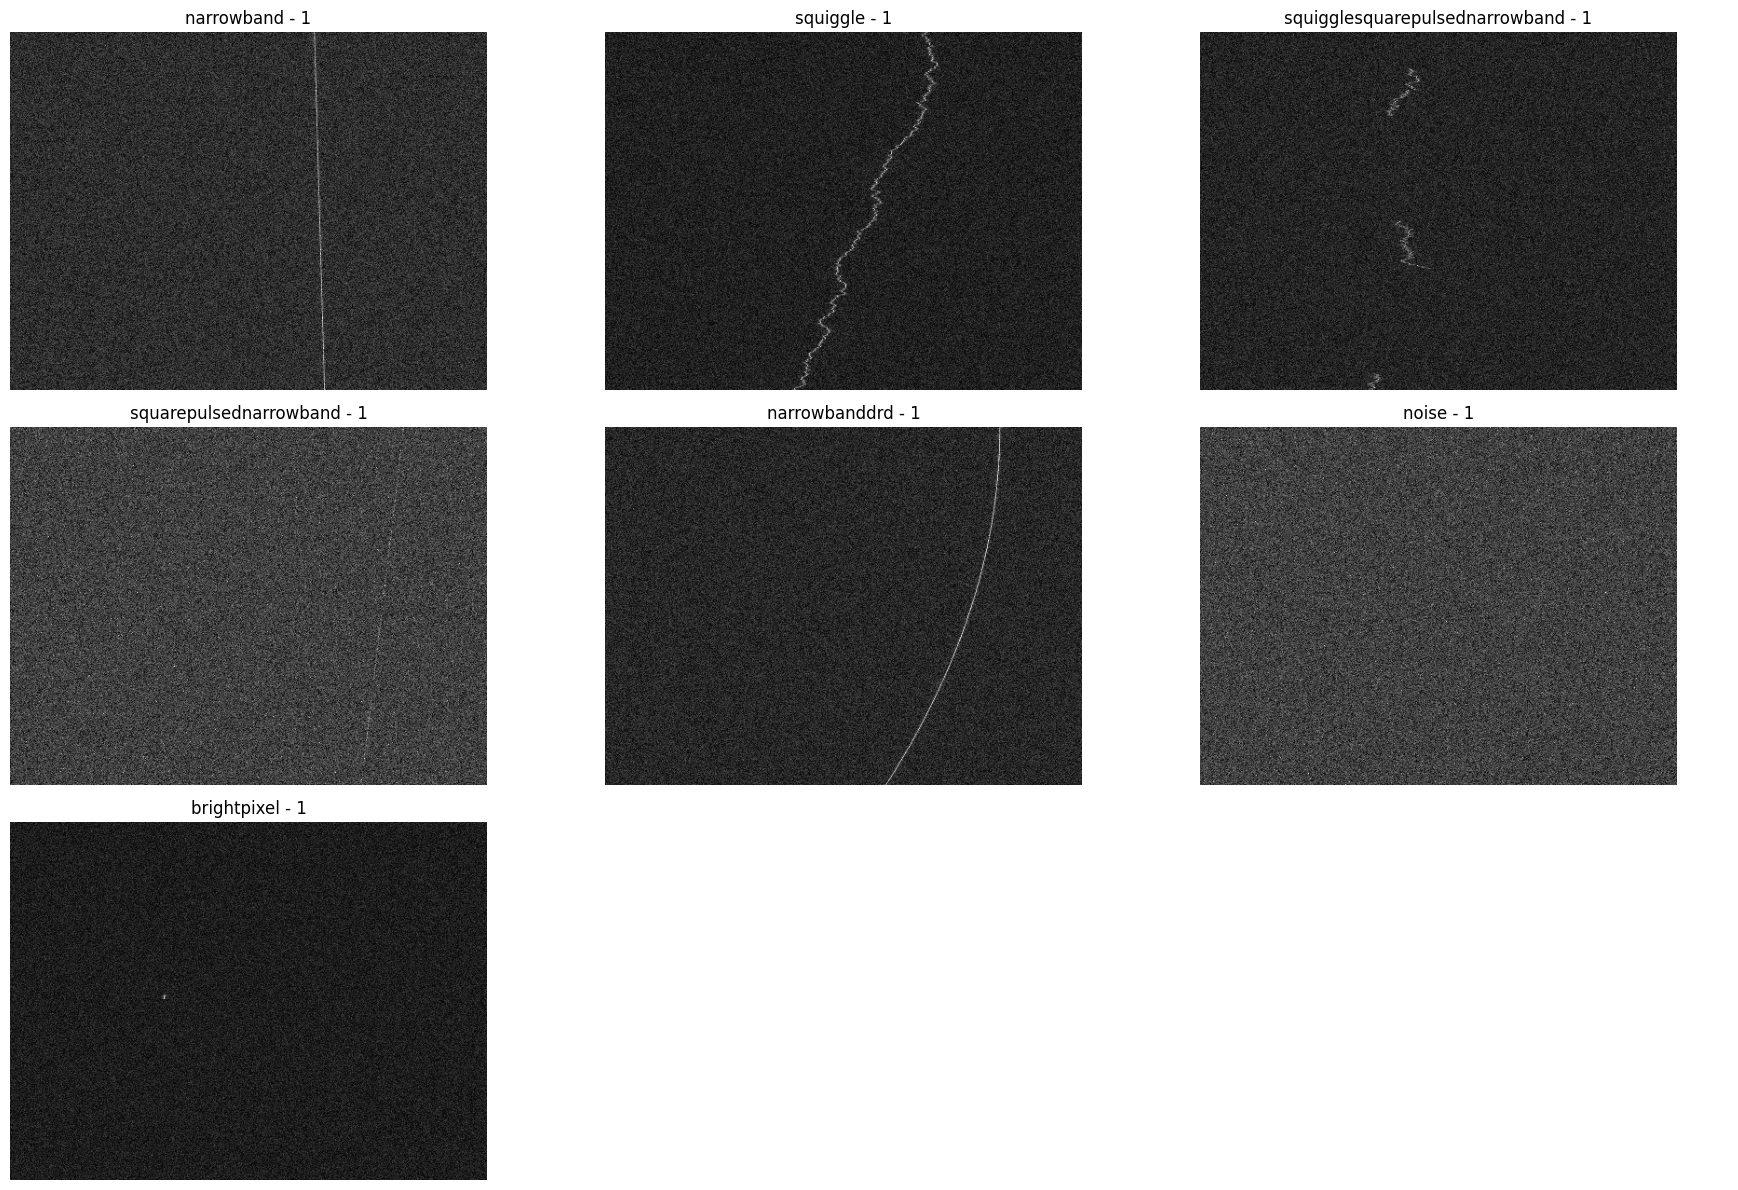

In [33]:
def get_sample_images(signal_types, n_samples=1, seed=42):
    """Get sample images for each signal type with a fixed seed for reproducibility"""
    np.random.seed(seed)
    sample_paths = {}
    
    for signal_type in signal_types:
        all_paths = list((raw_dir / signal_type).glob('*.png'))
        if n_samples >= len(all_paths):
            selected_paths = all_paths
        else:
            selected_indices = np.random.choice(len(all_paths), n_samples, replace=False)
            selected_paths = [all_paths[i] for i in selected_indices]
        
        sample_paths[signal_type] = selected_paths
    
    return sample_paths

def plot_images_sample(signal_types, n_samples=1, sample_paths=None):
    # Calculate number of rows needed (3 images per row)
    n_cols = 3
    n_rows = (len(signal_types) * n_samples + n_cols - 1) // n_cols
    
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(18, 4*n_rows))
    axes = axes.flatten()
    
    # Get sample images if not provided
    if sample_paths is None:
        sample_paths = get_sample_images(signal_types, n_samples)
    
    idx = 0
    for signal_type in signal_types:
        for i, img_path in enumerate(sample_paths[signal_type]):
            if idx < len(axes):
                img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
                axes[idx].imshow(img, cmap='gray')
                axes[idx].set_title(f'{signal_type} - {i+1}')
                axes[idx].axis('off')
                idx += 1
    
    # Hide any unused subplots
    for i in range(idx, len(axes)):
        axes[i].axis('off')
        
    plt.tight_layout()
    plt.show()
    
    return sample_paths

# Get and plot sample images
sample_image_paths = plot_images_sample(signal_types, n_samples=1)


In [34]:
# Get the absolute path to the project root
PROJECT_ROOT = Path(os.getcwd()).parent if 'notebooks' in os.getcwd() else Path(os.getcwd())

# Update the paths to use absolute paths
sample_image_paths = {
    'narrowband': str(PROJECT_ROOT / 'data/raw/narrowband/183_narrowband.png'),
    'squiggle': str(PROJECT_ROOT / 'data/raw/squiggle/3850_squiggle.png'),
    'squigglesquarepulsednarrowband': str(PROJECT_ROOT / 'data/raw/squigglesquarepulsednarrowband/5380_squigglesquarepulsednarrowband.png'),
    'squarepulsednarrowband': str(PROJECT_ROOT / 'data/raw/squarepulsednarrowband/4455_squarepulsednarrowband.png'),
    'narrowbanddrd': str(PROJECT_ROOT / 'data/raw/narrowbanddrd/4840_narrowbanddrd.png'),
    'noise': str(PROJECT_ROOT / 'data/raw/noise/4698_noise.png'),
    'brightpixel': str(PROJECT_ROOT / 'data/raw/brightpixel/1360_brightpixel.png')
}

sample_image_paths

{'narrowband': '/Users/lmarte/Documents/Projects/CU-Boulder/Final-Proj/data/raw/narrowband/183_narrowband.png',
 'squiggle': '/Users/lmarte/Documents/Projects/CU-Boulder/Final-Proj/data/raw/squiggle/3850_squiggle.png',
 'squigglesquarepulsednarrowband': '/Users/lmarte/Documents/Projects/CU-Boulder/Final-Proj/data/raw/squigglesquarepulsednarrowband/5380_squigglesquarepulsednarrowband.png',
 'squarepulsednarrowband': '/Users/lmarte/Documents/Projects/CU-Boulder/Final-Proj/data/raw/squarepulsednarrowband/4455_squarepulsednarrowband.png',
 'narrowbanddrd': '/Users/lmarte/Documents/Projects/CU-Boulder/Final-Proj/data/raw/narrowbanddrd/4840_narrowbanddrd.png',
 'noise': '/Users/lmarte/Documents/Projects/CU-Boulder/Final-Proj/data/raw/noise/4698_noise.png',
 'brightpixel': '/Users/lmarte/Documents/Projects/CU-Boulder/Final-Proj/data/raw/brightpixel/1360_brightpixel.png'}

## 3. Preprocessing Pipeline

Let's define the preprocessing pipeline and apply it to the sample images.






Preprocessing steps for narrowband:


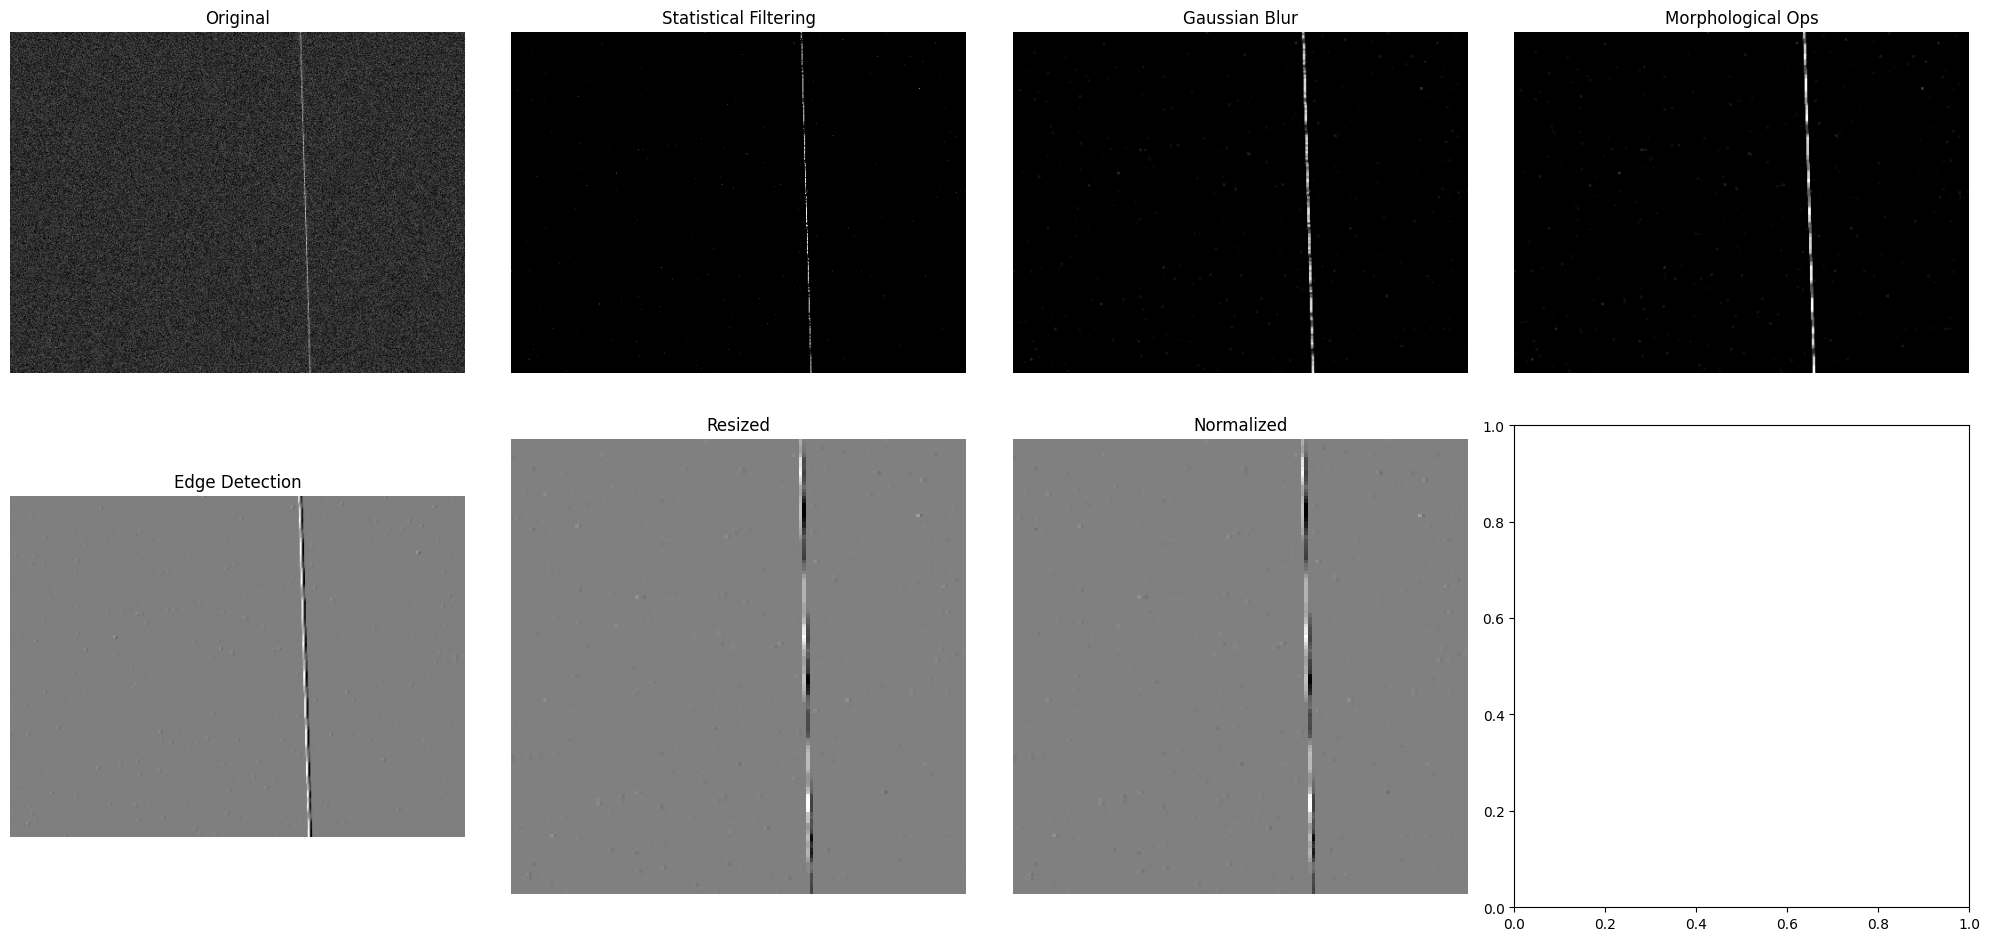


Preprocessing steps for squiggle:


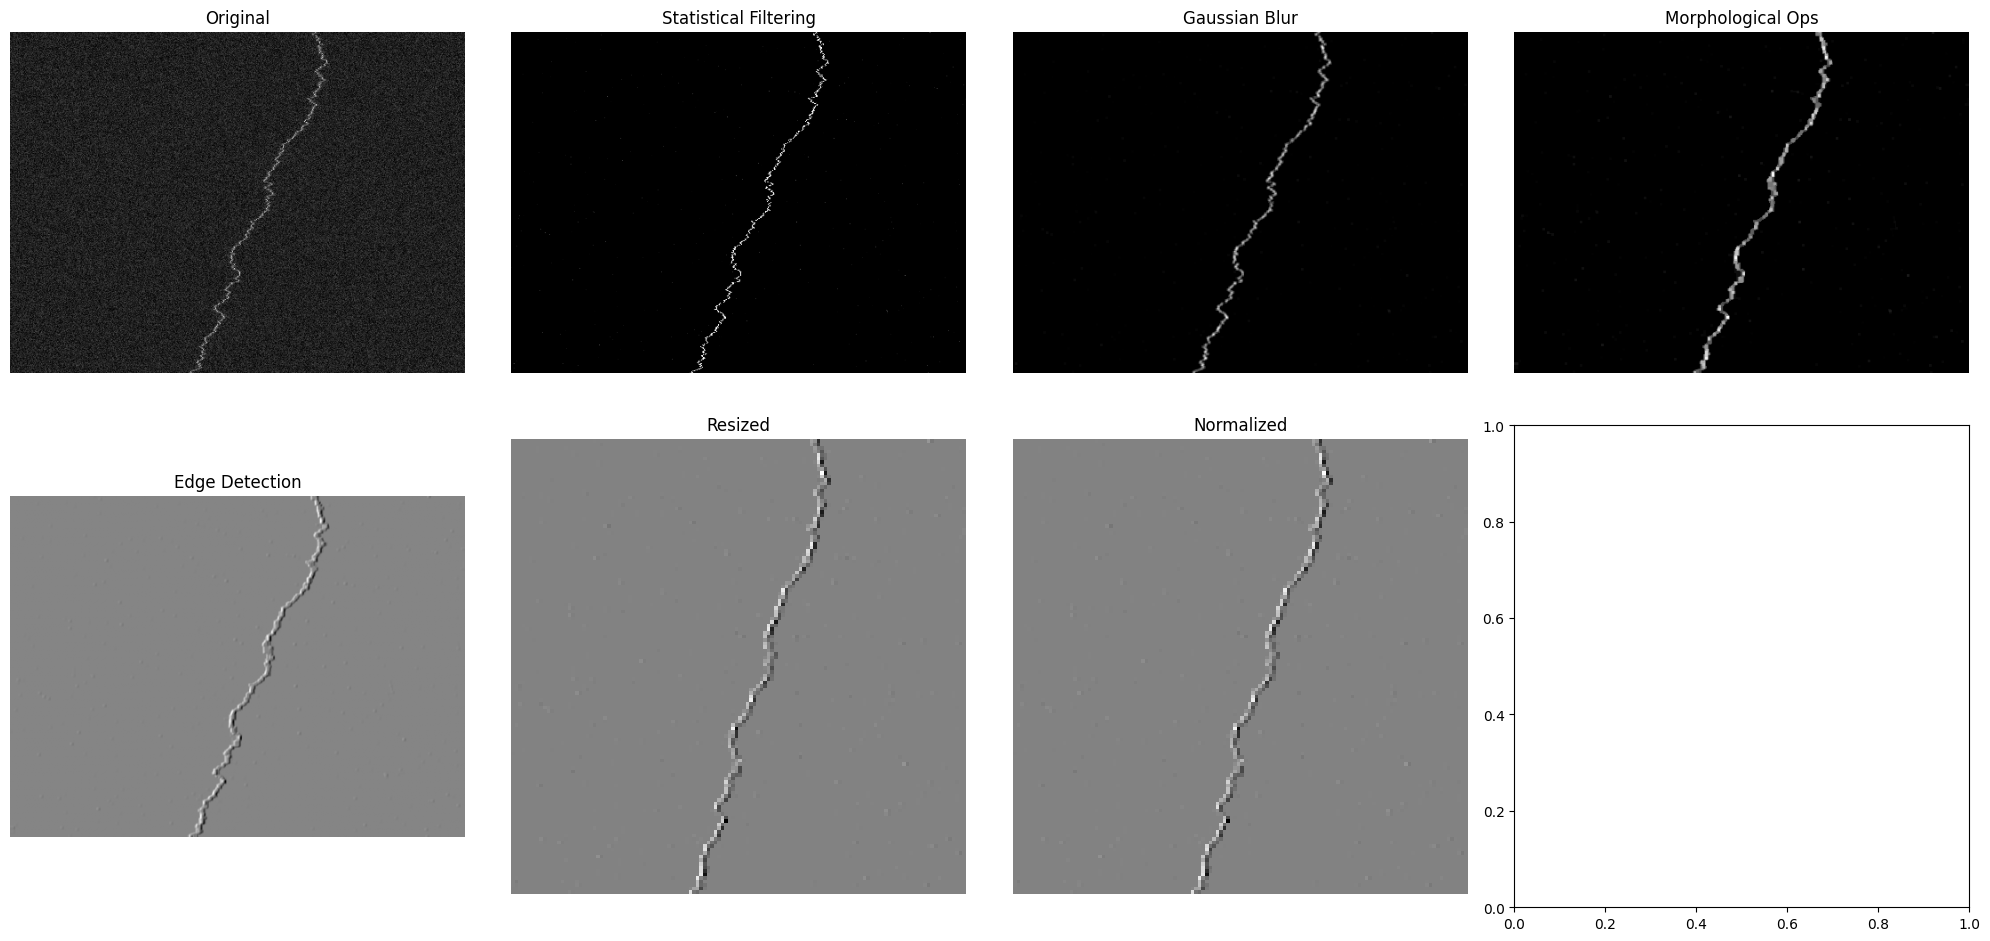


Preprocessing steps for squigglesquarepulsednarrowband:


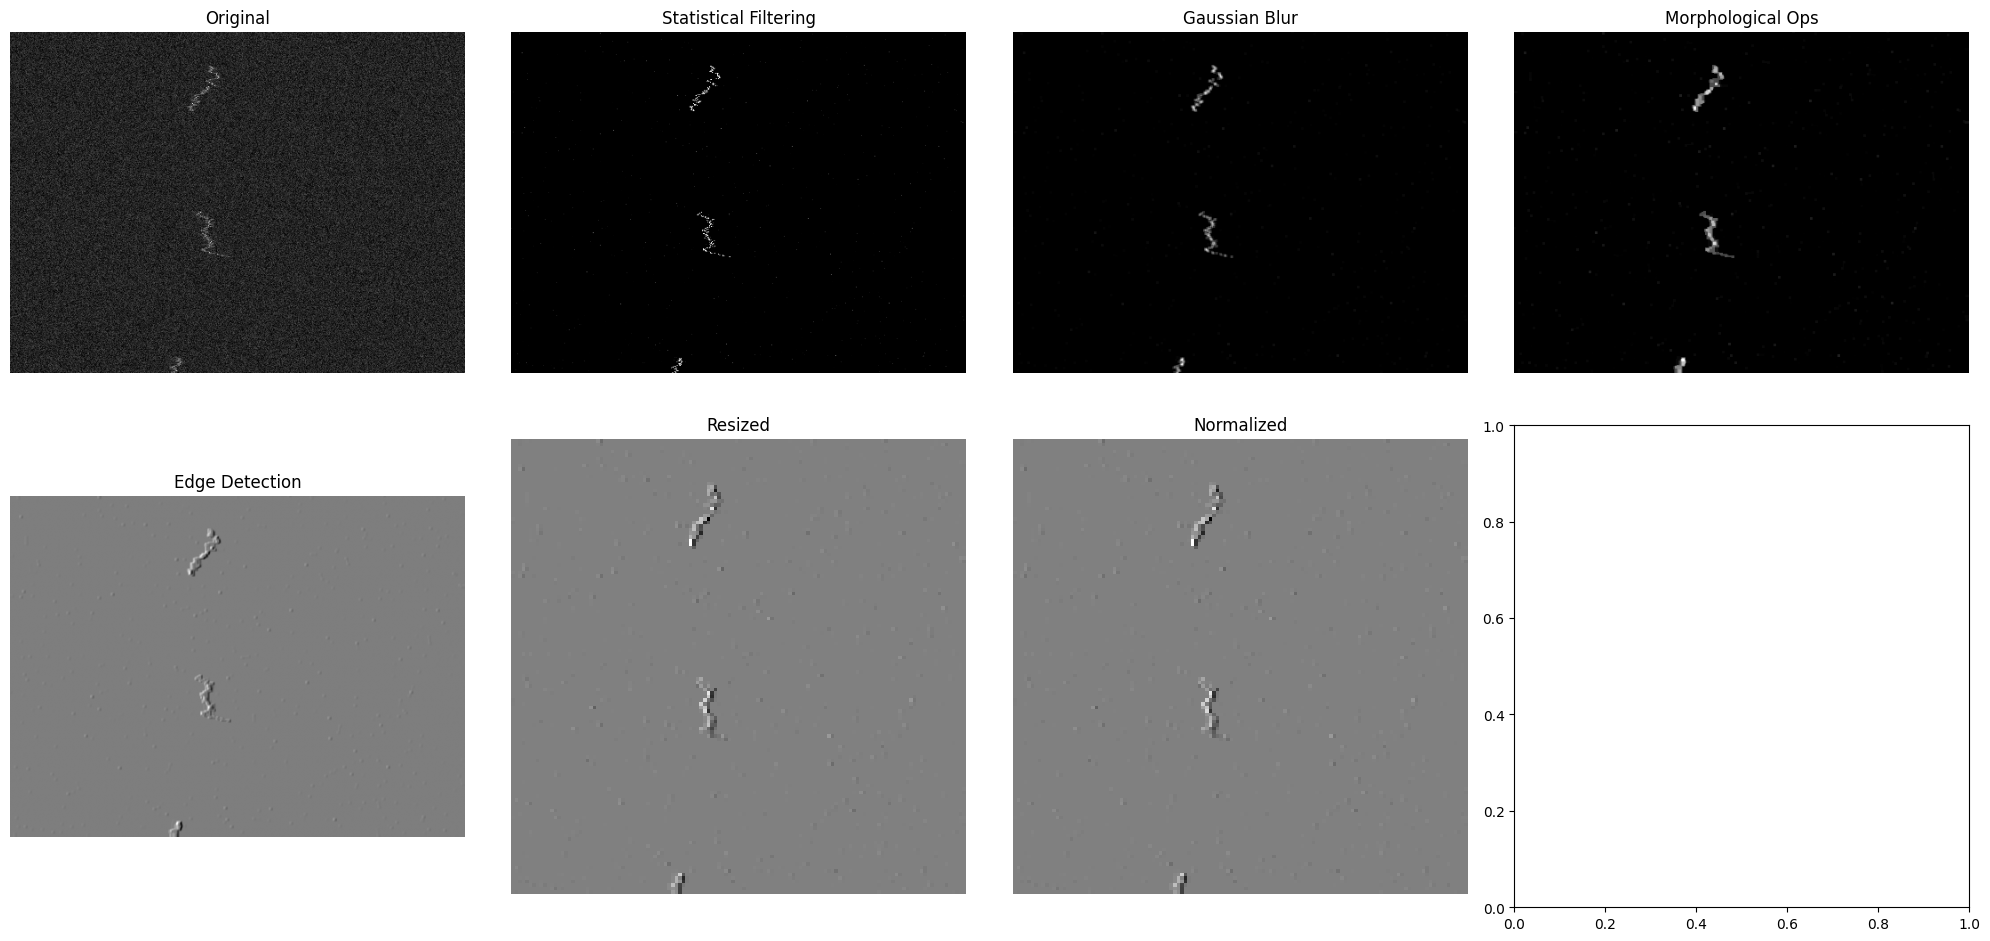


Preprocessing steps for squarepulsednarrowband:


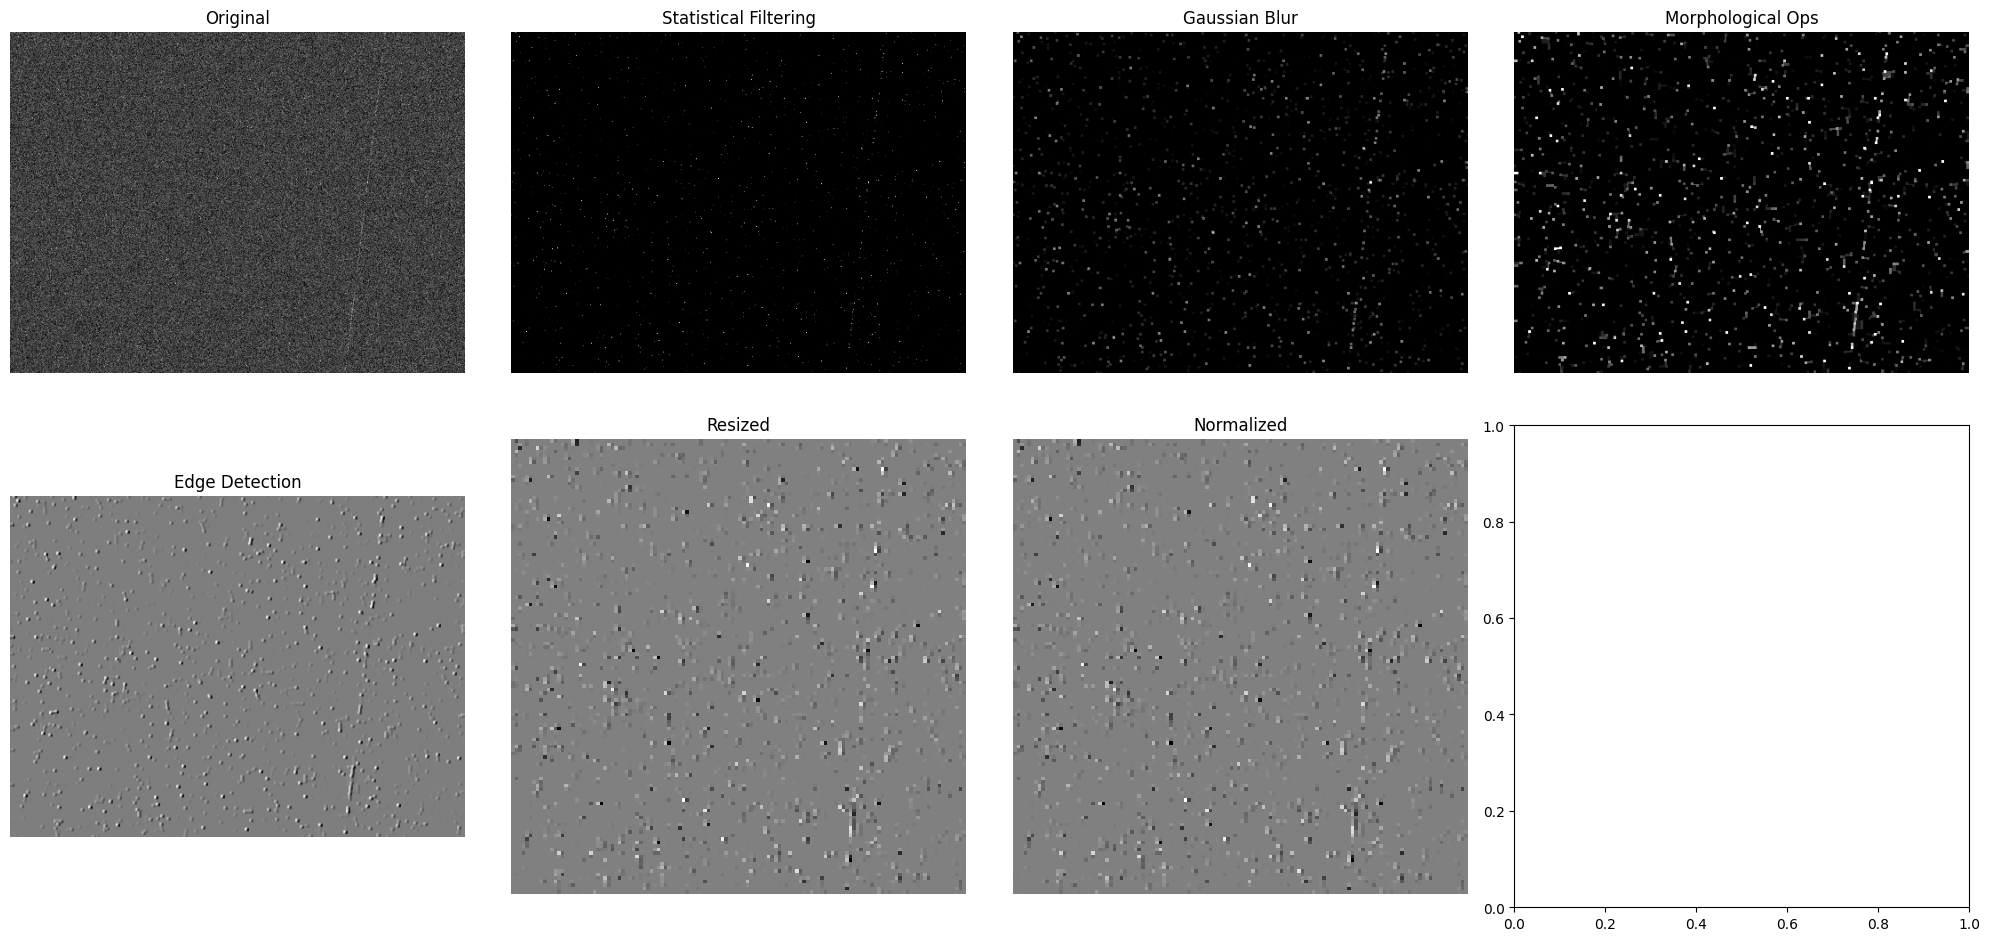


Preprocessing steps for narrowbanddrd:


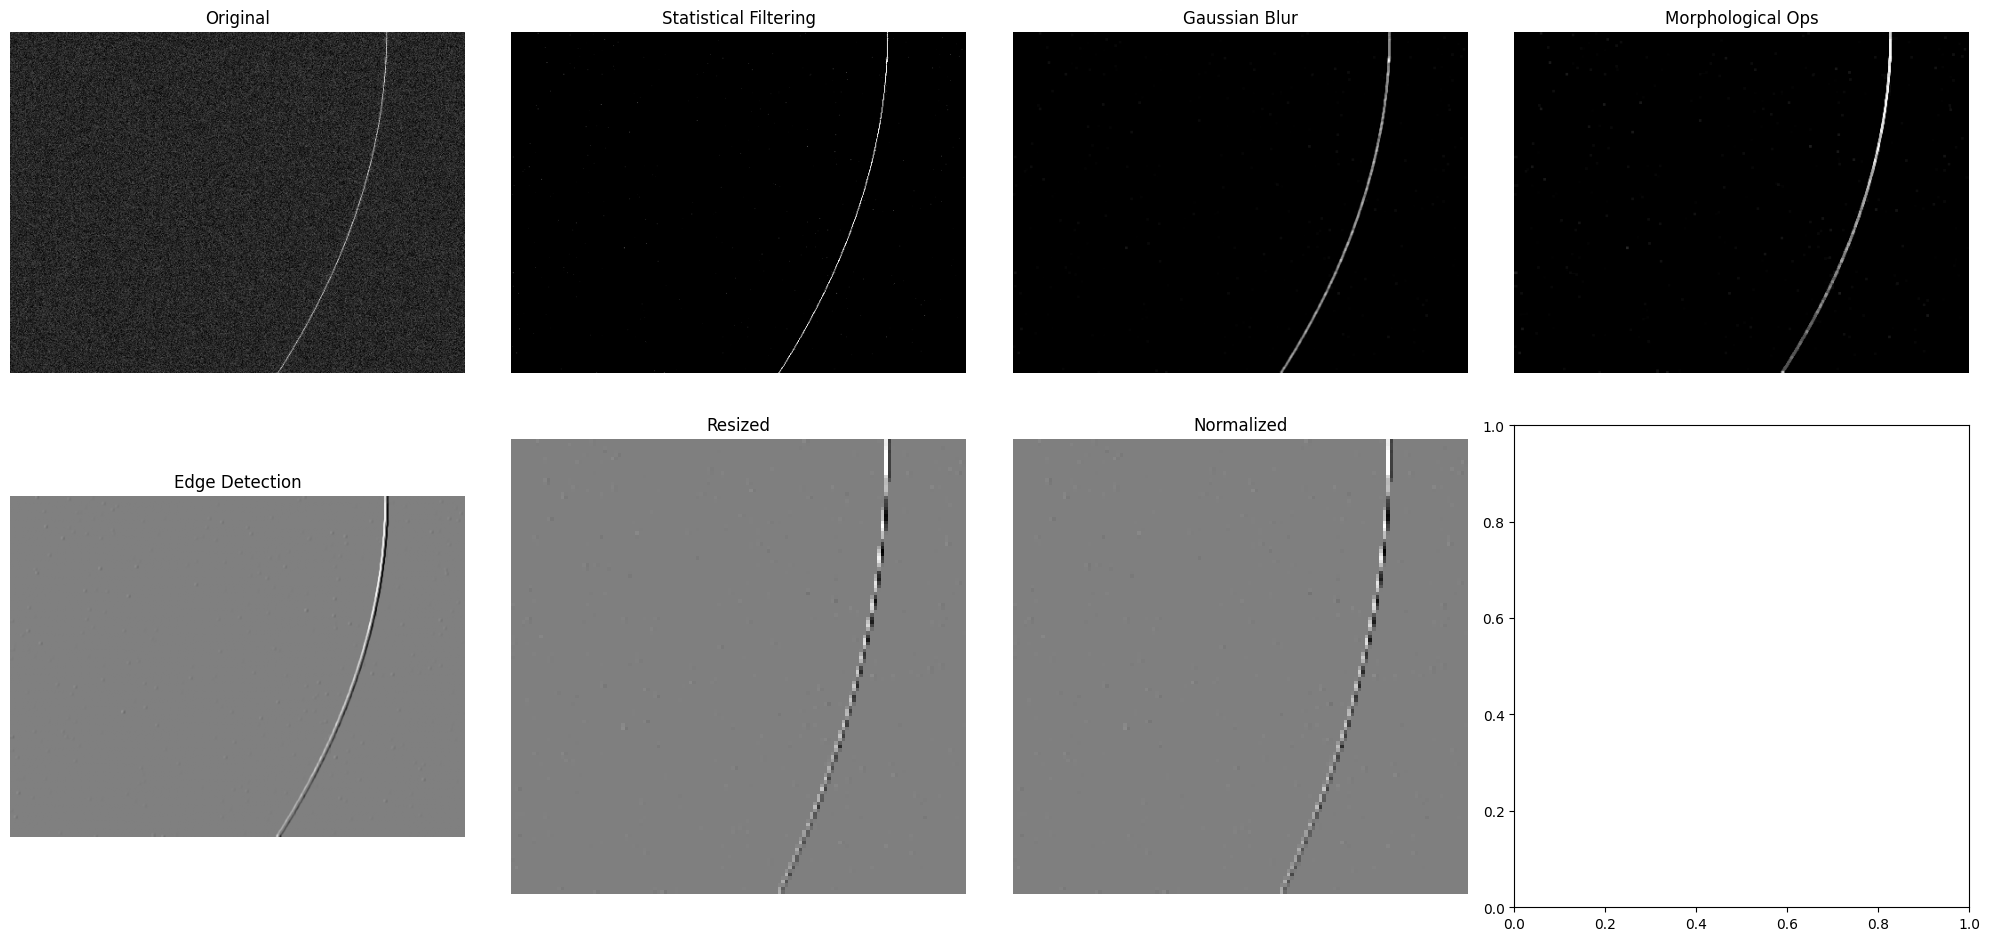


Preprocessing steps for noise:


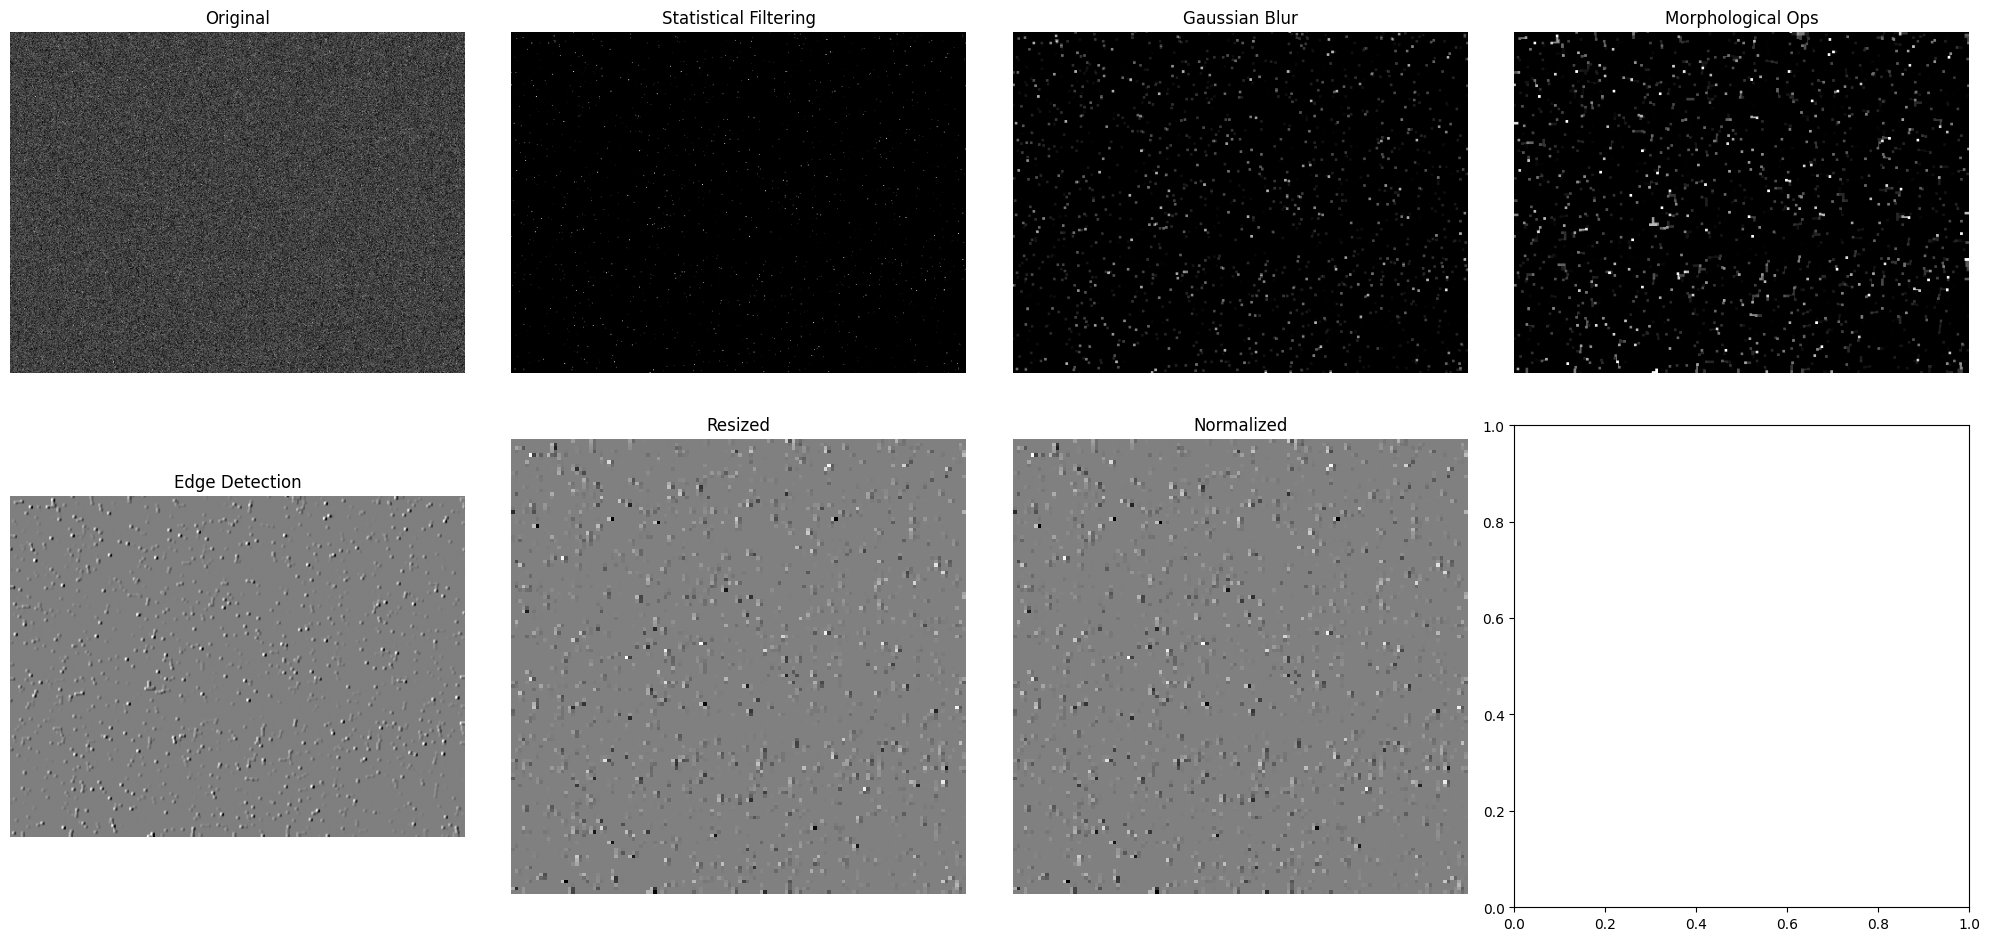


Preprocessing steps for brightpixel:


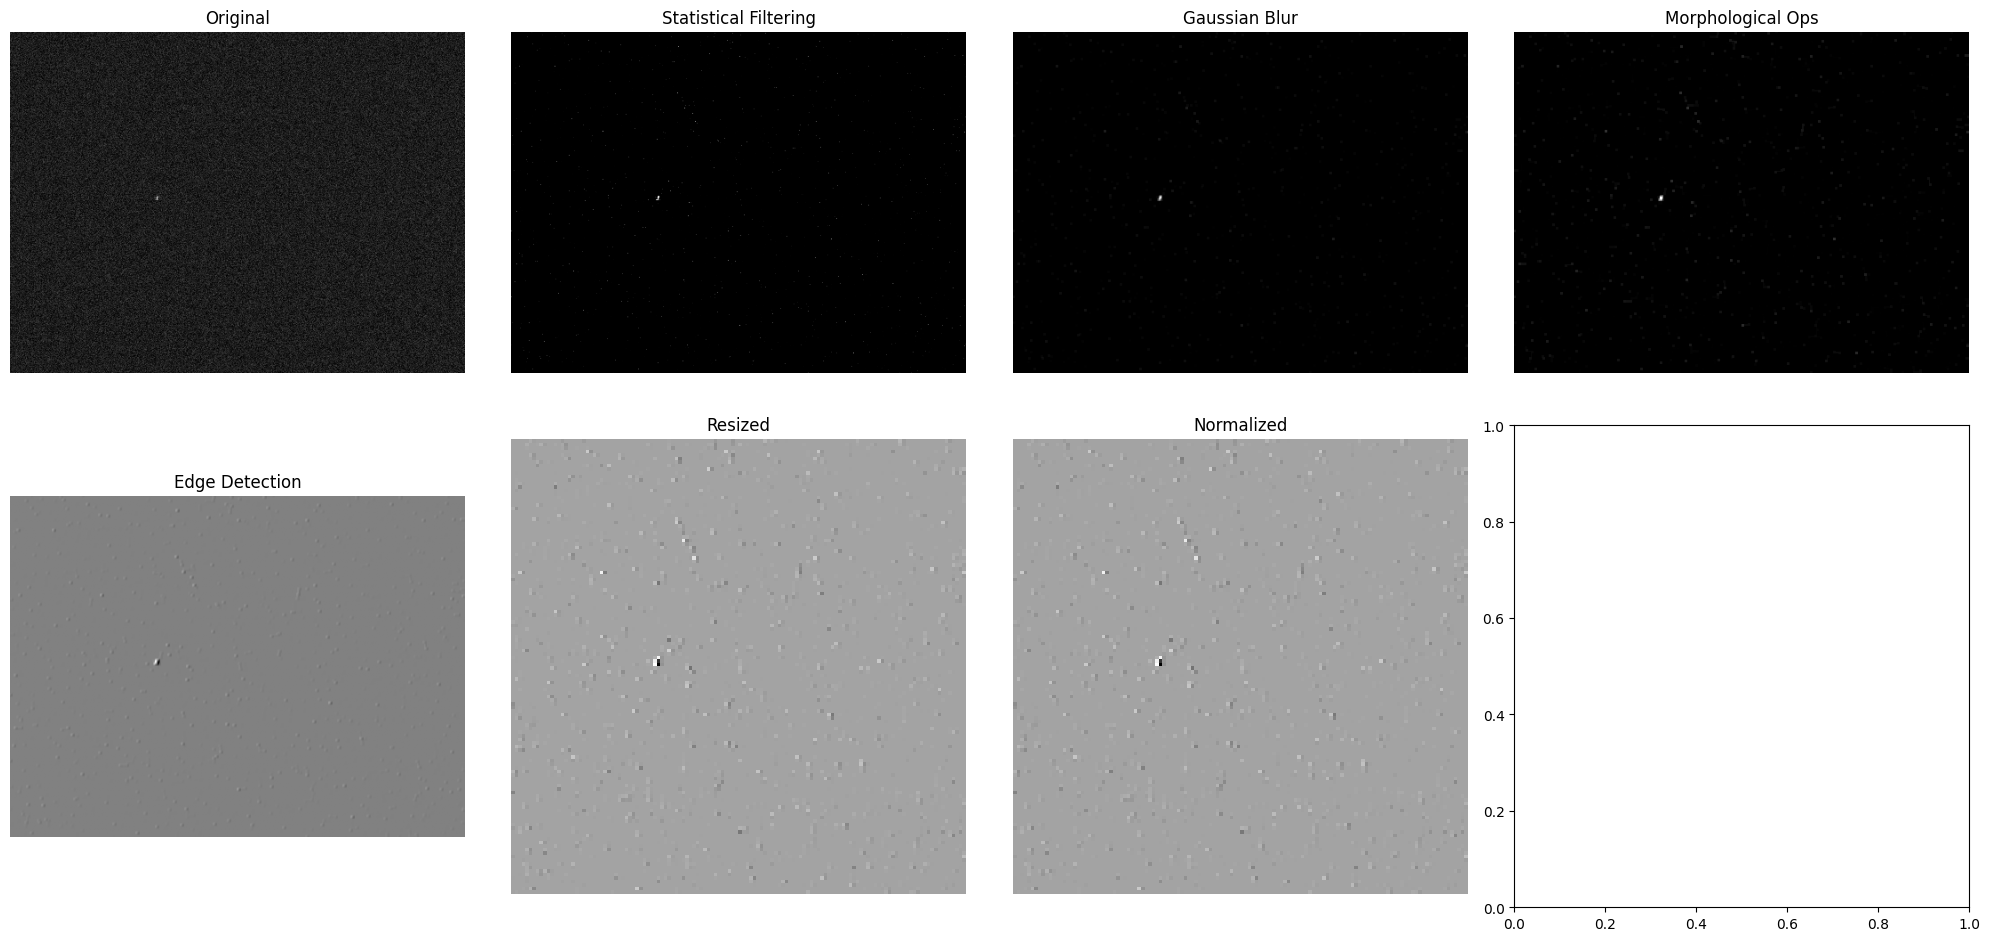

In [35]:
def visualize_preprocessing_steps(img_path):
    # Load original image
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    
    if img is None:
        print(f"Error: Could not read image at {img_path}")
        return
    
    # Statistical filtering
    std = np.std(img)
    mean = np.mean(img)
    img_clipped = np.clip(img, mean + (2.5*std), mean + (5*std))
    
    # Gaussian blur
    gaussian = cv2.GaussianBlur(img_clipped, (3, 3), 5)
    
    # Morphological operations
    kernel3 = np.ones((3, 3), dtype=np.float32)
    kernel5 = np.ones((5, 5), dtype=np.float32)
    morphed = cv2.morphologyEx(gaussian, cv2.MORPH_OPEN, kernel=kernel3)
    morphed = cv2.morphologyEx(morphed, cv2.MORPH_CLOSE, kernel=kernel5)
    
    # Edge detection
    sobelx = cv2.Sobel(morphed, cv2.CV_64F, 1, 0, 10)
    sobely = cv2.Sobel(morphed, cv2.CV_64F, 0, 1, 10)
    blended = cv2.addWeighted(src1=sobelx, alpha=0.9, src2=sobely, beta=0.3, gamma=0.25)
    
    # Resize and normalize
    img_resized = cv2.resize(blended, (128,128))
    img_normalized = img_resized.astype(np.float32) / 255.0
    
    # Plot all steps
    fig, axes = plt.subplots(2, 4, figsize=(20, 10))
    steps = [('Original', img),
             ('Statistical Filtering', img_clipped),
             ('Gaussian Blur', gaussian),
             ('Morphological Ops', morphed),
             ('Edge Detection', blended),
             ('Resized', img_resized),
             ('Normalized', img_normalized)]
    
    for (title, img_step), ax in zip(steps, axes.ravel()):
        ax.imshow(img_step, cmap='gray')
        ax.set_title(title)
        ax.axis('off')
    
    plt.tight_layout()
    plt.show()

# Visualize preprocessing steps for sample images and save preprocessed images
preprocessed_images = {}
for signal_type in signal_types:
    print(f"\nPreprocessing steps for {signal_type}:")
    img_path = sample_image_paths[signal_type]
    visualize_preprocessing_steps(img_path)
    
    # Load and preprocess the image for later use
    img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"Error: Could not read image at {img_path}")
        continue
    
    # Apply the same preprocessing steps as in visualize_preprocessing_steps
    std = np.std(img)
    mean = np.mean(img)
    img_clipped = np.clip(img, mean + (2.5*std), mean + (5*std))
    gaussian = cv2.GaussianBlur(img_clipped, (3, 3), 5)
    kernel3 = np.ones((3, 3), dtype=np.float32)
    kernel5 = np.ones((5, 5), dtype=np.float32)
    morphed = cv2.morphologyEx(gaussian, cv2.MORPH_OPEN, kernel=kernel3)
    morphed = cv2.morphologyEx(morphed, cv2.MORPH_CLOSE, kernel=kernel5)
    sobelx = cv2.Sobel(morphed, cv2.CV_64F, 1, 0, 10)
    sobely = cv2.Sobel(morphed, cv2.CV_64F, 0, 1, 10)
    blended = cv2.addWeighted(src1=sobelx, alpha=0.9, src2=sobely, beta=0.3, gamma=0.25)
    img_resized = cv2.resize(blended, (128,128))
    img_normalized = img_resized.astype(np.float32) / 255.0
    
    # Calculate intensity profiles
    vertical_profile = np.mean(img_normalized, axis=1)
    horizontal_profile = np.mean(img_normalized, axis=0)
    
    # Store preprocessed image and profiles
    preprocessed_images[signal_type] = {
        'image': img_normalized,
        'vertical_profile': vertical_profile,
        'horizontal_profile': horizontal_profile
    }


Preprocessing steps for narrowband:


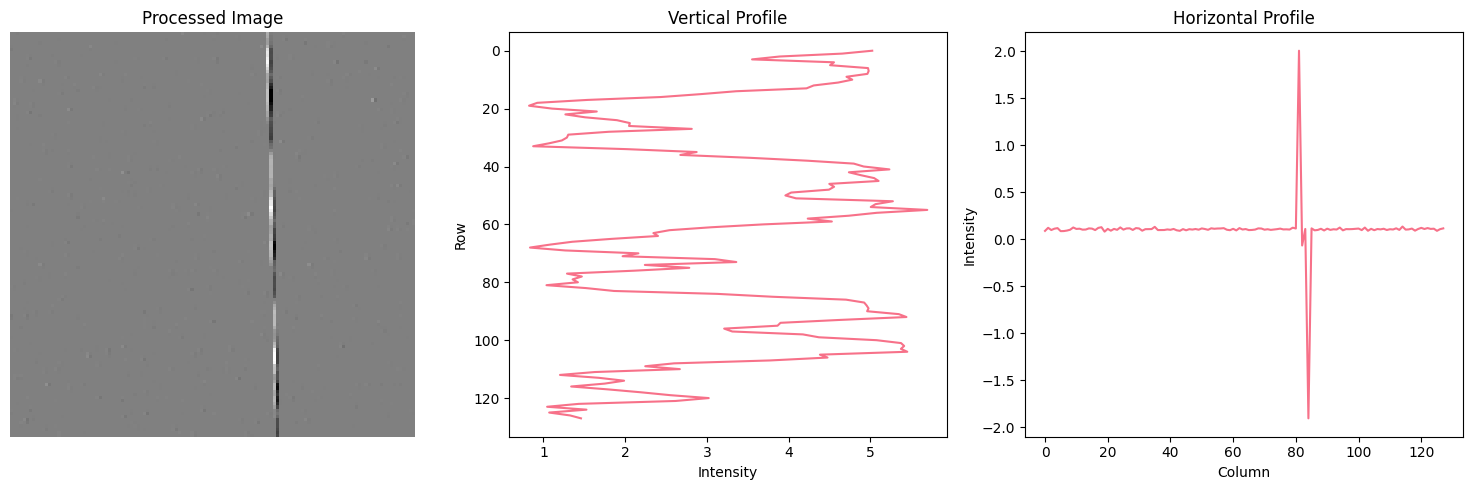


Preprocessing steps for squiggle:


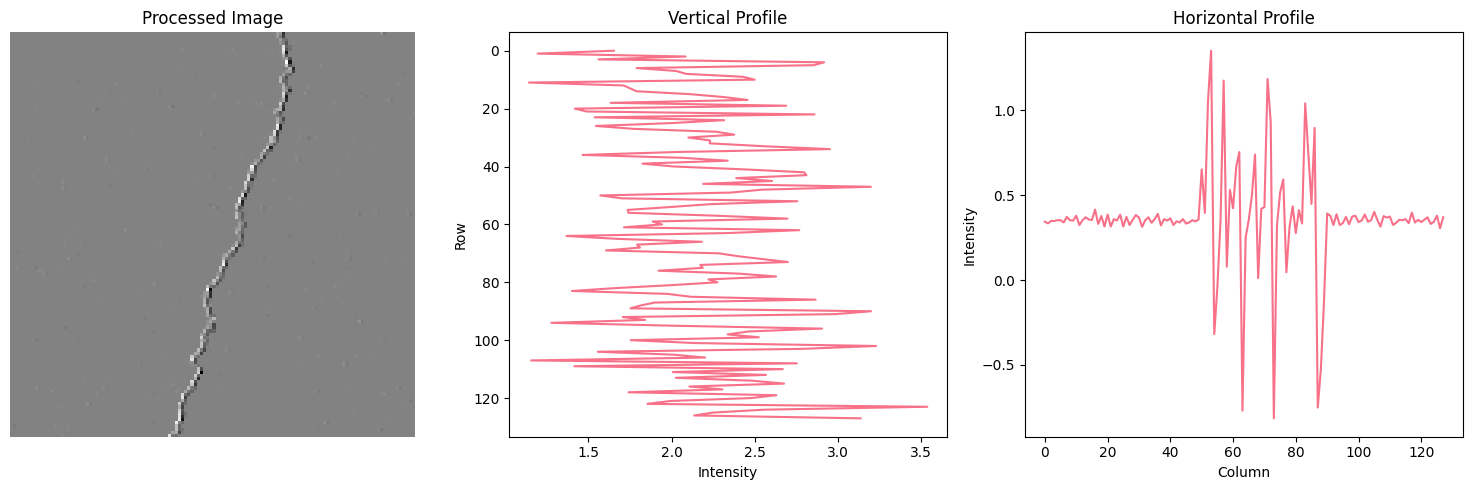


Preprocessing steps for squigglesquarepulsednarrowband:


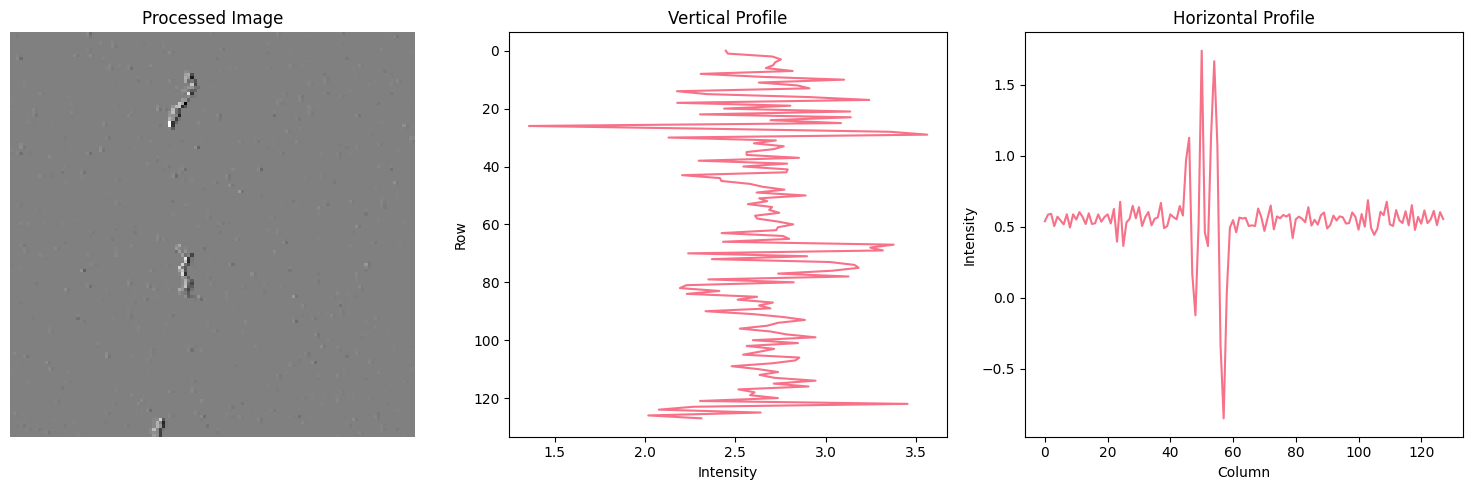


Preprocessing steps for squarepulsednarrowband:


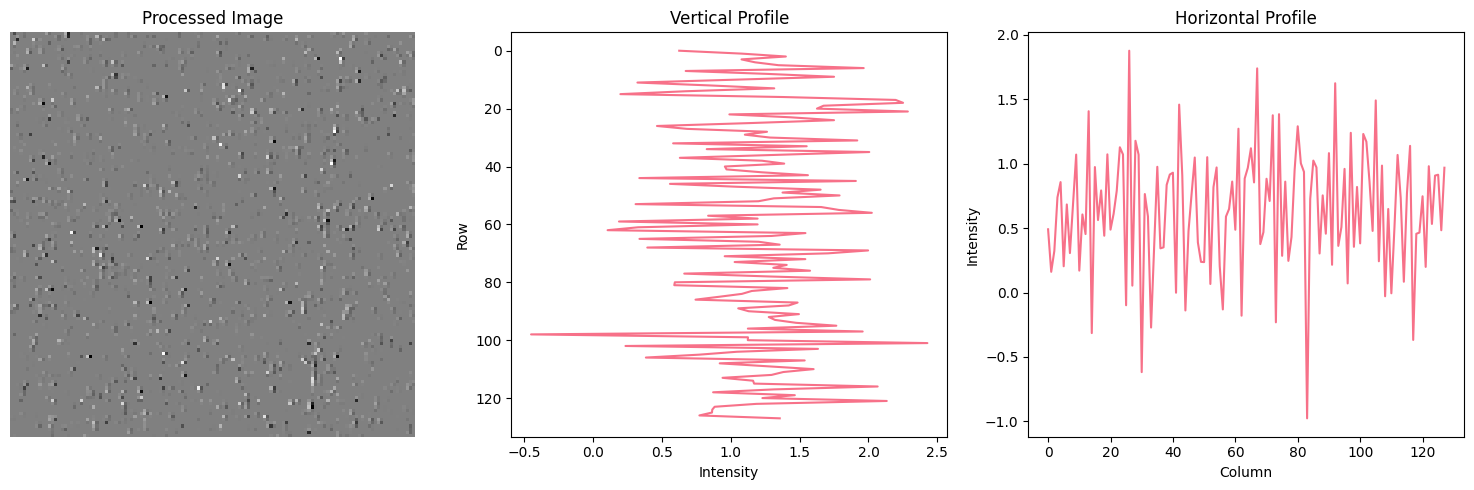


Preprocessing steps for narrowbanddrd:


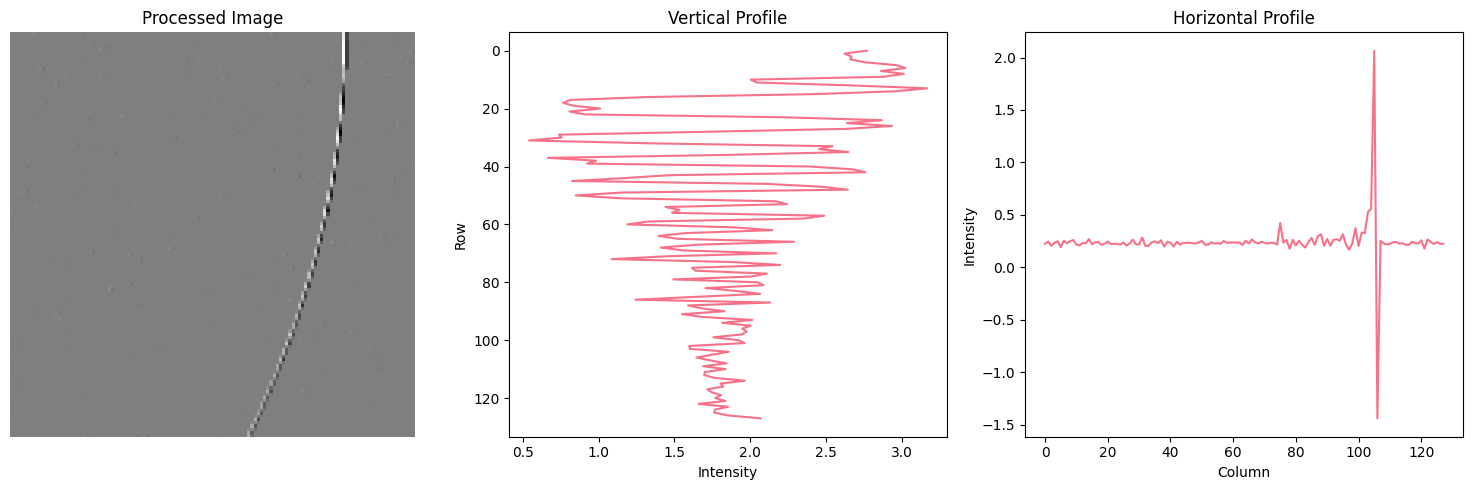


Preprocessing steps for noise:


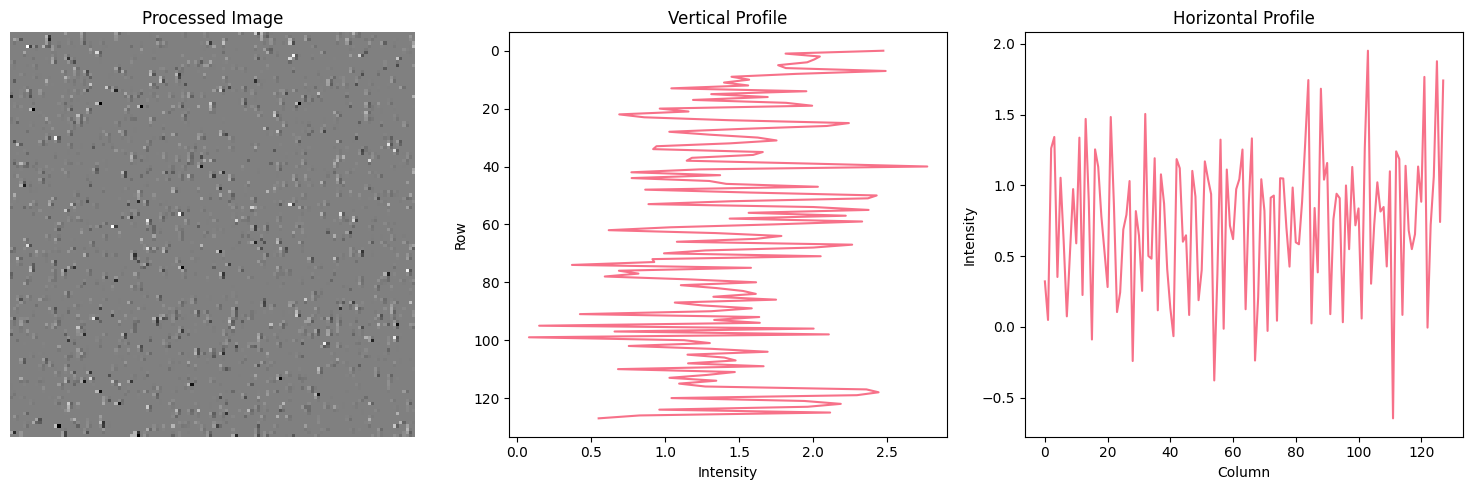


Preprocessing steps for brightpixel:


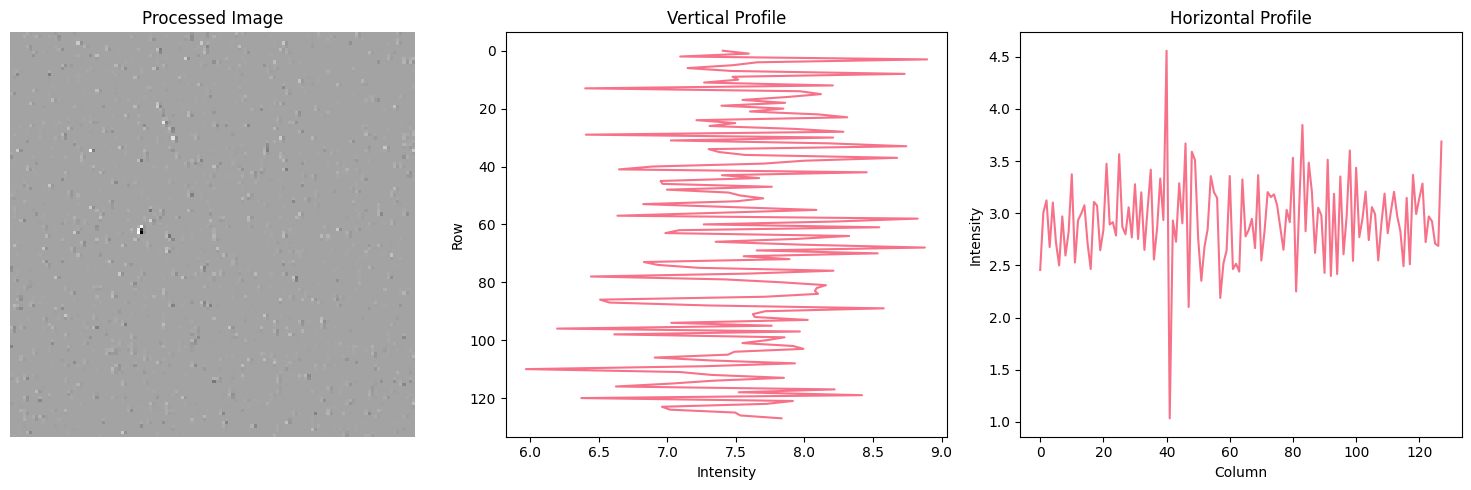

In [39]:
def plot_intensity_profiles(processed_img, vertical_profile, horizontal_profile):
    # Preprocess image and get profiles
    # processed_img, vertical_profile, horizontal_profile = preprocess_image(img_path)
    
    # Plot image and profiles
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 5))
    
    # Original image
    ax1.imshow(processed_img, cmap='gray')
    ax1.set_title('Processed Image')
    ax1.axis('off')
    
    # Vertical profile
    ax2.plot(vertical_profile, range(len(vertical_profile)))
    ax2.set_title('Vertical Profile')
    ax2.set_xlabel('Intensity')
    ax2.set_ylabel('Row')
    ax2.invert_yaxis()
    
    # Horizontal profile
    ax3.plot(range(len(horizontal_profile)), horizontal_profile)
    ax3.set_title('Horizontal Profile')
    ax3.set_xlabel('Column')
    ax3.set_ylabel('Intensity')
    
    plt.tight_layout()
    plt.show()

# Visualize preprocessing steps for sample images and save preprocessed images
preprocessed_images = {}
for signal_type in signal_types:
    print(f"\nPreprocessing steps for {signal_type}:")
    img_path = sample_image_paths[signal_type]
    # visualize_preprocessing_steps(img_path)
    
    # Load and preprocess the image for later use
    img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"Error: Could not read image at {img_path}")
        continue
    
    # Apply the same preprocessing steps as in visualize_preprocessing_steps
    std = np.std(img)
    mean = np.mean(img)
    img_clipped = np.clip(img, mean + (2.5*std), mean + (5*std))
    gaussian = cv2.GaussianBlur(img_clipped, (3, 3), 5)
    kernel3 = np.ones((3, 3), dtype=np.float32)
    kernel5 = np.ones((5, 5), dtype=np.float32)
    morphed = cv2.morphologyEx(gaussian, cv2.MORPH_OPEN, kernel=kernel3)
    morphed = cv2.morphologyEx(morphed, cv2.MORPH_CLOSE, kernel=kernel5)
    sobelx = cv2.Sobel(morphed, cv2.CV_64F, 1, 0, 10)
    sobely = cv2.Sobel(morphed, cv2.CV_64F, 0, 1, 10)
    blended = cv2.addWeighted(src1=sobelx, alpha=0.9, src2=sobely, beta=0.3, gamma=0.25)
    img_resized = cv2.resize(blended, (128, 128))
    img_normalized = img_resized.astype(np.float32) / 255.0
    
    # Calculate intensity profiles
    vertical_profile = np.mean(img_normalized, axis=1)
    horizontal_profile = np.mean(img_normalized, axis=0)
    
    # Compute gradients
    vertical_gradient = np.gradient(vertical_profile)
    horizontal_gradient = np.gradient(horizontal_profile)

    # Normalize gradients
    vertical_profile = vertical_profile / np.max(np.abs(vertical_gradient))
    horizontal_profile = horizontal_profile / np.max(np.abs(horizontal_gradient))
    
    # Store preprocessed image and profiles
    preprocessed_images[signal_type] = {
        'image': img_normalized,
        'vertical_profile': vertical_profile,
        'horizontal_profile': horizontal_profile
    }
    
    plot_intensity_profiles(img_normalized, vertical_profile, horizontal_profile)
    

# Plot profiles for one image from each class
# for signal_type in signal_types:
#     print(f"\nIntensity profiles for {signal_type}:")
#     img_path = next((raw_dir / signal_type).glob('*.png'))
#     plot_intensity_profiles(img_path)

## 5. Batch Processing

Let's process all images in the dataset and save the preprocessed images and profiles.





In [8]:
import sys
sys.path.append('..')
from src.preprocess import preprocess_all_data

preprocess_all_data()

Processing narrowband...


Processing narrowband:  11%|█         | 109/999 [00:00<00:07, 126.96it/s]/Users/lmarte/Documents/Projects/CU-Boulder/Final-Proj/notebooks/../src/preprocess.py:31: RuntimeWarning: invalid value encountered in divide
  vertical_profile = vertical_gradient / np.max(np.abs(vertical_gradient))
Processing narrowband: 100%|██████████| 999/999 [00:07<00:00, 126.40it/s]


Processing squiggle...


Processing squiggle: 100%|██████████| 999/999 [00:07<00:00, 134.28it/s]


Processing squigglesquarepulsednarrowband...


Processing squigglesquarepulsednarrowband: 100%|██████████| 999/999 [00:07<00:00, 128.98it/s]


Processing squarepulsednarrowband...


Processing squarepulsednarrowband: 100%|██████████| 999/999 [00:07<00:00, 128.79it/s]


Processing narrowbanddrd...


Processing narrowbanddrd: 100%|██████████| 999/999 [00:07<00:00, 128.24it/s]


Processing noise...


Processing noise: 100%|██████████| 999/999 [00:07<00:00, 124.99it/s]


Processing brightpixel...


Processing brightpixel: 100%|██████████| 999/999 [00:07<00:00, 128.58it/s]




---

Rundown:
1. Feature Loading and Combination
- Loads processed images and intensity profiles
- Combines them into a feature matrix
- Creates a structured DataFrame for analysis
2. Feature Distribution Analysis
- Visualizes statistical features across signal types
- Helps identify distinguishing characteristics
- Shows how features vary between classes
3. Dimensionality Reduction
- Applies PCA and UMAP for visualization
- Shows how well features separate different signal types
- Helps identify potential clusters
4. Clustering Analysis
- Performs K-means clustering
- Analyzes optimal number of clusters
- Evaluates clustering quality using silhouette scores
5. Feature Importance
- Analyzes PCA loadings
- Shows explained variance
- Identifies most important features
After running this analysis, you'll have insights into:
- Which features best distinguish signal types
- How well the data clusters naturally
- Which dimensionality reduction technique works best
- The optimal number of clusters

The next steps would be:
1. Implement anomaly detection (using noise as the normal class)
2. Fine-tune clustering parameters
3. Build a classification pipeline
4. Evaluate model performance

## Feature Loading and Combination

In [7]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pathlib import Path
from tqdm.notebook import tqdm
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import umap.umap_ as umap

# Set style for visualizations
plt.style.use('seaborn-v0_8-dark-palette')
sns.set_palette('husl')

## 1. Feature Loading and Combination
First, Let's load the processed images and intensity profiles then combine them into a feature matrix.

In [8]:
def load_features():
    """Load processed images and intensity profiles, combine into feature matrix."""
    processed_dir = Path('../data/processed')
    profiles_dir = Path('../data/profiles')
    
    features_list = []
    labels = []
    
    for signal_type in tqdm(processed_dir.iterdir(), desc='Loading features'):
        if not signal_type.is_dir():
            continue
            
        for img_path in signal_type.glob('*.png'):
            # Load processed image
            img = cv2.imread(str(img_path), cv2.IMREAD_GRAYSCALE)
            img = img.astype(np.float32) / 255.0
            
            # Load intensity profiles
            profile_path = profiles_dir / f"{img_path.stem}_profiles.npz"
            profiles = np.load(str(profile_path))
            
            # Extract features
            features = {
                'flattened': img.flatten(),
                'vertical_profile': profiles['vertical'],
                'horizontal_profile': profiles['horizontal'],
                'max': np.max(img),
                'min': np.min(img),
                'mean': np.mean(img),
                'std': np.std(img),
                'skewness': np.mean((img - np.mean(img))**3) / (np.std(img)**3),
                'kurtosis': np.mean((img - np.mean(img))**4) / (np.std(img)**4)
            }
            
            features_list.append(features)
            labels.append(signal_type.name)
    
    return features_list, labels

# Load features
features_list, labels = load_features()

# Convert to DataFrame
df = pd.DataFrame(features_list)
df['label'] = labels

print(f"Loaded {len(df)} samples with {len(df.columns)-1} features")

Loading features: 0it [00:00, ?it/s]

Loaded 6993 samples with 9 features


## 2, Feature Analysis
Let's analyze the distribution of the features across the signal types.

/var/folders/dh/7y1zdj_56195j764wf4b6w8m0000gn/T/ipykernel_29870/2169145577.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/var/folders/dh/7y1zdj_56195j764wf4b6w8m0000gn/T/ipykernel_29870/2169145577.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/var/folders/dh/7y1zdj_56195j764wf4b6w8m0000gn/T/ipykernel_29870/2169145577.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
/var/folders/dh/7y1zdj_56195j764wf4b6w8m0000gn/T/ipykernel_29870/2169145577.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedL

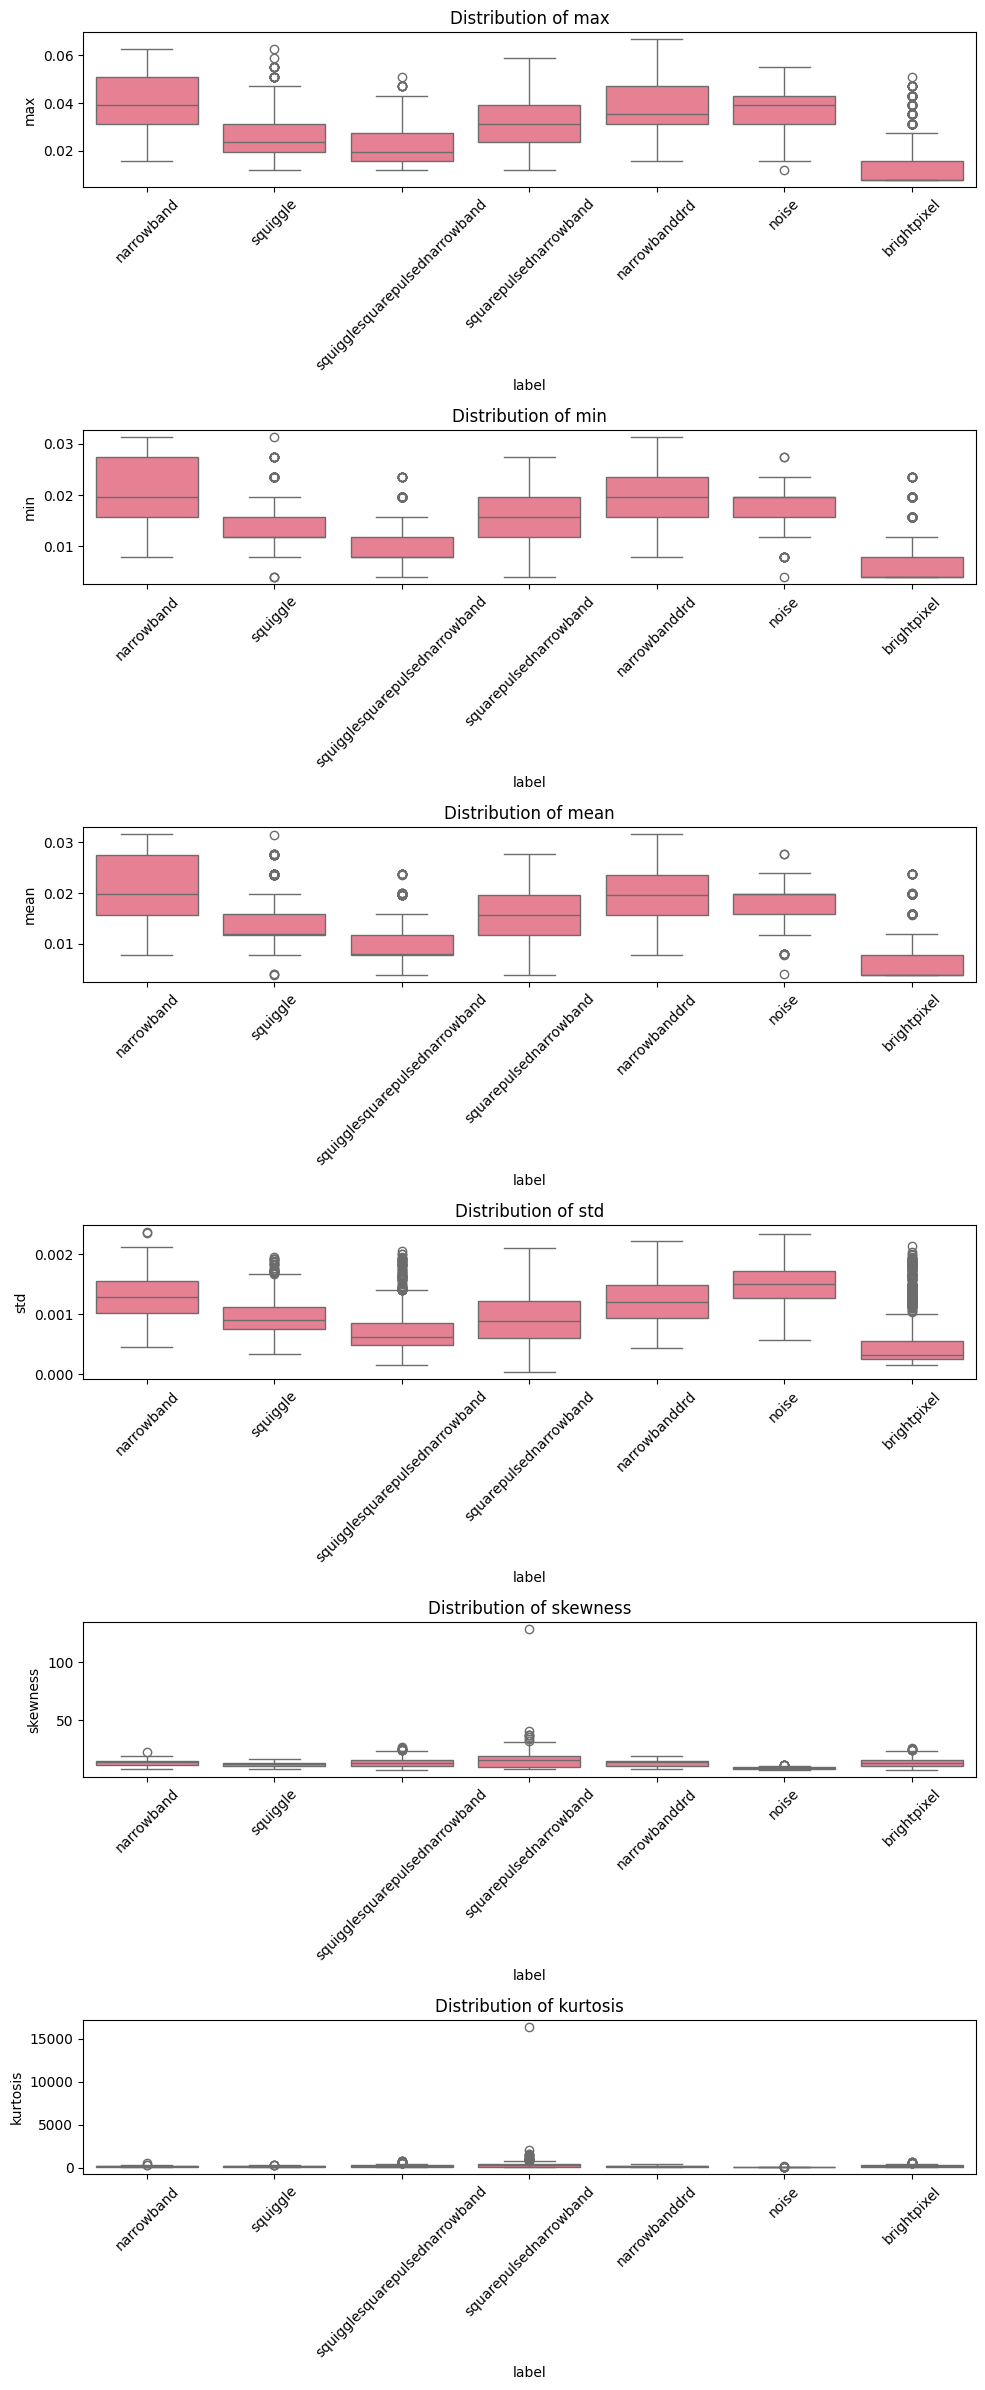

In [9]:
def plot_feature_distributions(df, features):
    """Plot distributions of selected features by signal type."""
    n_features = len(features)
    fig, axes = plt.subplots(n_features, 1, figsize=(10, 4*n_features))
    
    for ax, feature in zip(axes, features):
        sns.boxplot(data=df, x='label', y=feature, ax=ax)
        ax.set_xticklabels(ax.get_xticklabels(), rotation=45)
        ax.set_title(f'Distribution of {feature}')
    
    plt.tight_layout()
    plt.show()

# Plot distributions of statistical features
statistical_features = ['max', 'min', 'mean', 'std', 'skewness', 'kurtosis']
plot_feature_distributions(df, statistical_features)

## 3. Dimensionality Reduction
Let's visualize the features in a 2D space using PCA and UMAP.

/Users/lmarte/Documents/Projects/CU-Boulder/Final-Proj/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/lmarte/Documents/Projects/CU-Boulder/Final-Proj/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/lmarte/Documents/Projects/CU-Boulder/Final-Proj/.venv/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(


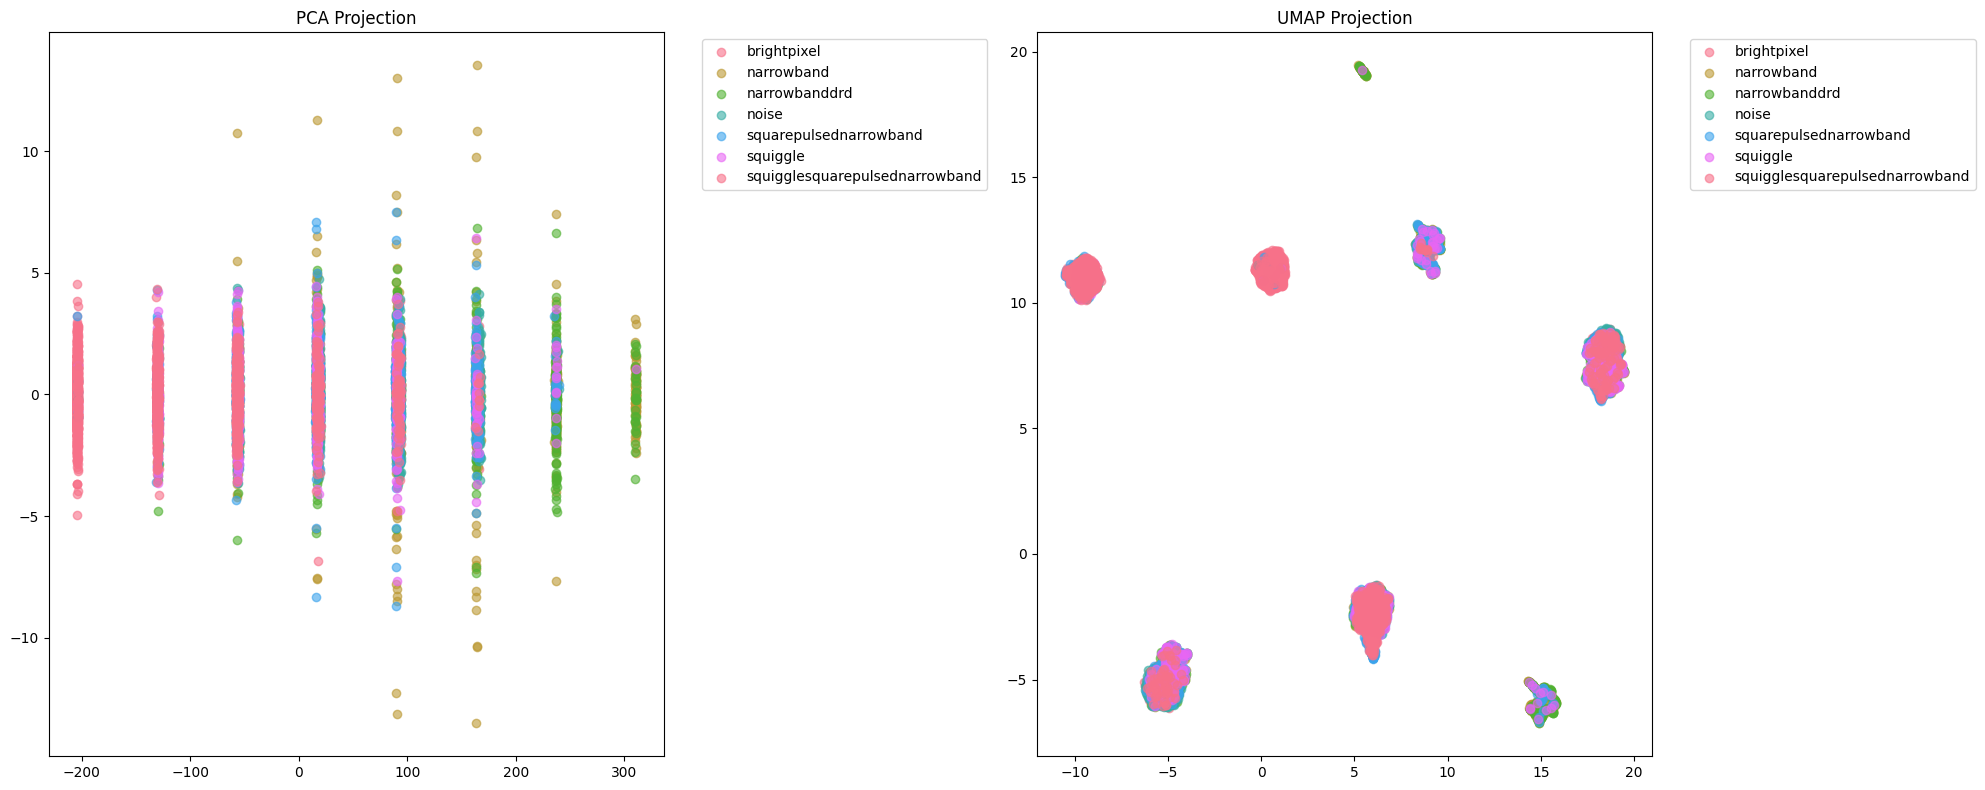

In [10]:
def reduce_dimensions(df):
    # Find and remove rows with NaN profiles
    nan_mask = ~df['vertical_profile'].apply(lambda x: np.isnan(x).any())
    df_clean = df[nan_mask]
    
    # Process image data
    X_img = np.vstack(df_clean['flattened'])
    X_img_scaled = StandardScaler().fit_transform(X_img)
    pca_img = PCA(n_components=50).fit_transform(X_img_scaled)
    
    # Process profiles
    X_profiles = np.column_stack([
        np.vstack(df_clean['vertical_profile']),
        np.vstack(df_clean['horizontal_profile'])
    ])
    X_profiles_scaled = StandardScaler().fit_transform(X_profiles)
    pca_profiles = PCA(n_components=10).fit_transform(X_profiles_scaled)
    
    # Process statistical features
    stat_features = ['max', 'min', 'mean', 'std', 'skewness', 'kurtosis']
    X_stats = df_clean[stat_features].values
    X_stats_scaled = StandardScaler().fit_transform(X_stats)
    
    # Combine all features
    X_combined = np.column_stack([
        pca_img,          # 50 components
        pca_profiles,     # 10 components
        X_stats_scaled    # 6 components
    ])
    
    # Final dimensionality reduction
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_combined)
    
    reducer = umap.UMAP(random_state=42)
    X_umap = reducer.fit_transform(X_combined)
    
    return X_pca, X_umap, df_clean['label'], X_combined  # Return the cleaned labels too

def plot_reduced_dimensions(X_pca, X_umap, labels):
    """Plot PCA and UMAP results."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
    
    # Plot PCA
    for label in np.unique(labels):
        mask = labels == label
        ax1.scatter(X_pca[mask, 0], X_pca[mask, 1], label=label, alpha=0.6)
    ax1.set_title('PCA Projection')
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # Plot UMAP
    for label in np.unique(labels):
        mask = labels == label
        ax2.scatter(X_umap[mask, 0], X_umap[mask, 1], label=label, alpha=0.6)
    ax2.set_title('UMAP Projection')
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    plt.tight_layout()
    plt.show()

# Reduce dimensions and plot
X_pca, X_umap, clean_labels, X_combined = reduce_dimensions(df)  # Get cleaned labels
plot_reduced_dimensions(X_pca, X_umap, clean_labels)  # Use cleaned labels

Looking at both projections, we can make several important observations:
1. UMAP Projection (Right):
- Shows much better class separation than PCA
- Forms distinct clusters for different signal types
- The classes are well-segregated with minimal overlap
- This suggests that UMAP has successfully captured the non-linear relationships between features
- Particularly good at separating brightpixel and narrowbanddrd signals from others
2. PCA Projection (Left):
- Shows a more spread out, striped pattern
- Less clear separation between classes
- Signals appear to be distributed in vertical bands
- This linear projection suggests there might be some periodic or scale-based features that PCA is picking up
- The spread along the x-axis (PC1) might represent variation in signal intensity or scale
3. Overall Insights:
- The data is inherently non-linear (hence UMAP's better separation)
- The signal types have distinct characteristics that allow for classification
- Some signal types (like brightpixel) have very distinctive features that make them easily separable
- The combined feature set (image data, profiles, and statistical features) contains good discriminative information

---
## 4. Clustering Analysis
Let's perform K-means clustering and analyze the results.



Silhouette score (PCA): 0.953
Silhouette score (UMAP): 0.892


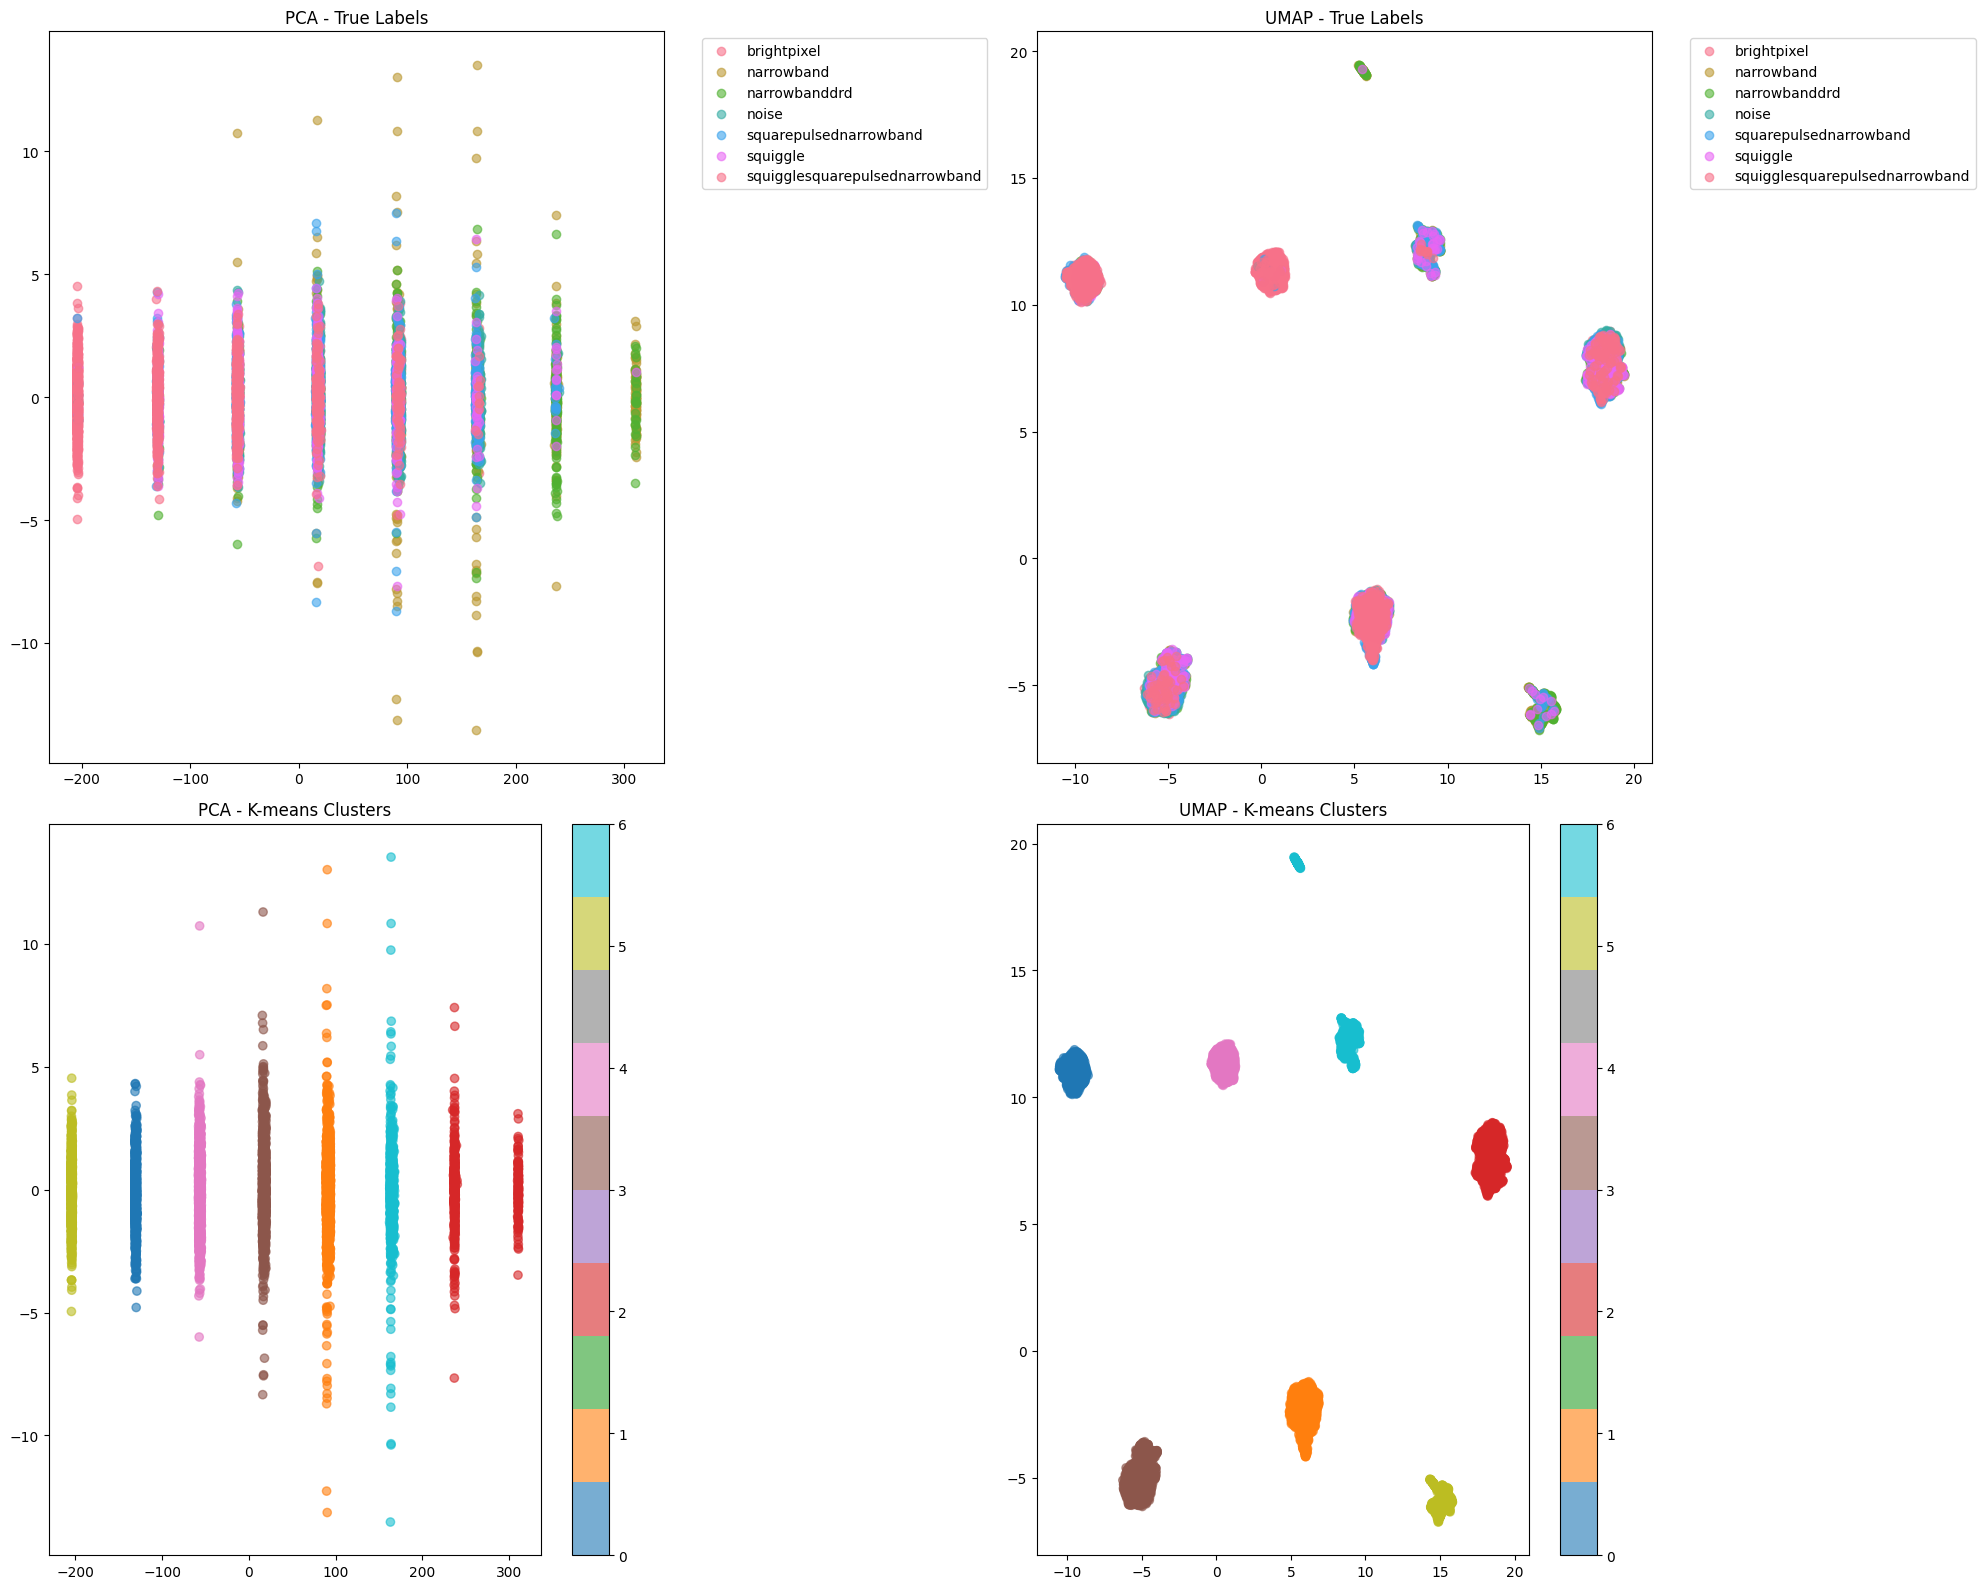

In [11]:
def analyze_clusters(X_pca, X_umap, true_labels):
    """Analyze clustering on both PCA and UMAP projections"""
    # Number of known classes
    n_clusters = len(np.unique(true_labels))
    
    # Fit K-means on both projections
    kmeans_pca = KMeans(n_clusters=n_clusters, random_state=42)
    kmeans_umap = KMeans(n_clusters=n_clusters, random_state=42)
    
    # Get cluster assignments
    clusters_pca = kmeans_pca.fit_predict(X_pca)
    clusters_umap = kmeans_umap.fit_predict(X_umap)
    
    # Calculate silhouette scores
    sil_pca = silhouette_score(X_pca, clusters_pca)
    sil_umap = silhouette_score(X_umap, clusters_umap)
    
    print(f"Silhouette score (PCA): {sil_pca:.3f}")
    print(f"Silhouette score (UMAP): {sil_umap:.3f}")
    
    # Plot results
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(20, 16))
    
    # Original labels
    for label in np.unique(true_labels):
        mask = true_labels == label
        ax1.scatter(X_pca[mask, 0], X_pca[mask, 1], label=label, alpha=0.6)
    ax1.set_title('PCA - True Labels')
    ax1.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    for label in np.unique(true_labels):
        mask = true_labels == label
        ax2.scatter(X_umap[mask, 0], X_umap[mask, 1], label=label, alpha=0.6)
    ax2.set_title('UMAP - True Labels')
    ax2.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
    
    # K-means clusters
    scatter1 = ax3.scatter(X_pca[:, 0], X_pca[:, 1], c=clusters_pca, cmap='tab10', alpha=0.6)
    ax3.set_title('PCA - K-means Clusters')
    plt.colorbar(scatter1, ax=ax3)
    
    scatter2 = ax4.scatter(X_umap[:, 0], X_umap[:, 1], c=clusters_umap, cmap='tab10', alpha=0.6)
    ax4.set_title('UMAP - K-means Clusters')
    plt.colorbar(scatter2, ax=ax4)
    
    plt.tight_layout()
    plt.show()
    
    return clusters_pca, clusters_umap

# Run clustering analysis
clusters_pca, clusters_umap = analyze_clusters(X_pca, X_umap, clean_labels)

These results are very interesting! Let's analyze what we're seeing:
1. Silhouette Scores:
- PCA: 0.953 - Exceptionally high!
- UMAP: 0.895 - Also very high
- Surprisingly, PCA has a higher silhouette score despite UMAP showing visually better separation
2. Clustering Performance:
- UMAP Clusters (Bottom Right):
    - Clear, well-defined clusters
    - Matches very well with the true labels (Top Right)
    - Each signal type gets its own distinct cluster
    - Minimal overlap between clusters
- PCA Clusters (Bottom Left):
    - Forms vertical stripe-like clusters
    - Despite looking less visually separated, the high silhouette score suggests these vertical bands are actually well-separated in the 2D space
    - The clustering aligns well with the periodic structure in the data
3. Key Insights:
- Both projections are capturing different aspects of the data structure
- PCA's higher silhouette score suggests the linear separation in vertical bands is actually very effective for clustering
- UMAP provides better visual separation but the non-linear transformation might introduce some distortion that slightly reduces the silhouette score

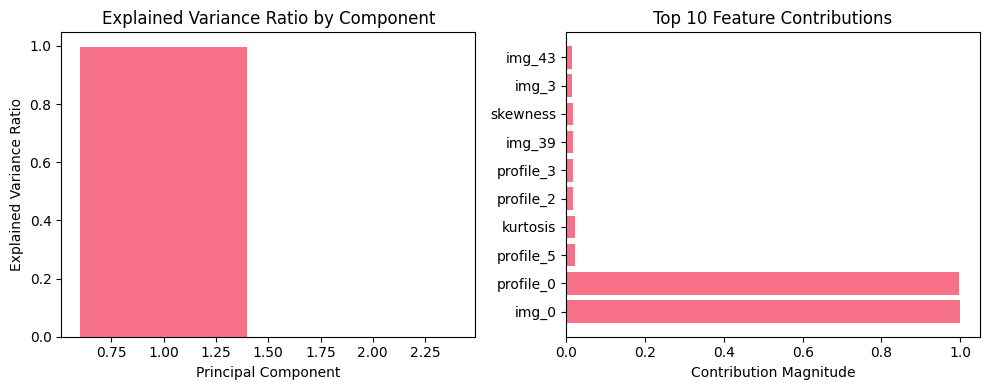


Top 10 Most Important Features:
      Feature  Total_Contribution
0       img_0            0.999886
50  profile_0            0.997314
55  profile_5            0.021570
65   kurtosis            0.021425
52  profile_2            0.018645
53  profile_3            0.018418
39     img_39            0.017197
64   skewness            0.016574
3       img_3            0.015781
43     img_43            0.015688

Contribution by Feature Type:
Image Features: 1.324
Profile Features: 1.098
Statistical Features: 0.070


In [12]:
def analyze_feature_importance(X_combined, pca, feature_names=None):
    """Analyze which features contribute most to the clustering"""
    # Get PCA components importance
    explained_var_ratio = pca.explained_variance_ratio_
    
    # Get feature contributions to first two PCs
    components = pca.components_[:2]  # Get first two components
    
    # If feature names not provided, create generic ones
    if feature_names is None:
        feature_names = [
            *[f'img_{i}' for i in range(50)],          # PCA image features
            *[f'profile_{i}' for i in range(10)],      # PCA profile features
            'max', 'min', 'mean', 'std', 'skewness', 'kurtosis'  # Statistical features
        ]
    
    # Create importance DataFrame
    importance_df = pd.DataFrame({
        'PC1': components[0],
        'PC2': components[1],
        'Feature': feature_names
    })
    
    # Calculate absolute contribution
    importance_df['Total_Contribution'] = np.sqrt(importance_df['PC1']**2 + importance_df['PC2']**2)
    
    # Sort by total contribution
    importance_df = importance_df.sort_values('Total_Contribution', ascending=False)
    
    # Plot explained variance
    plt.figure(figsize=(10, 4))
    plt.subplot(1, 2, 1)
    plt.bar(range(1, len(explained_var_ratio) + 1), explained_var_ratio)
    plt.title('Explained Variance Ratio by Component')
    plt.xlabel('Principal Component')
    plt.ylabel('Explained Variance Ratio')
    
    # Plot top feature contributions
    plt.subplot(1, 2, 2)
    top_n = 10
    plt.barh(importance_df['Feature'][:top_n], importance_df['Total_Contribution'][:top_n])
    plt.title(f'Top {top_n} Feature Contributions')
    plt.xlabel('Contribution Magnitude')
    
    plt.tight_layout()
    plt.show()
    
    # Print detailed information about top features
    print("\nTop 10 Most Important Features:")
    print(importance_df[['Feature', 'Total_Contribution']].head(10))
    
    # Group contribution by feature type
    feature_types = {
        'Image Features': importance_df[importance_df['Feature'].str.startswith('img_')]['Total_Contribution'].sum(),
        'Profile Features': importance_df[importance_df['Feature'].str.startswith('profile_')]['Total_Contribution'].sum(),
        'Statistical Features': importance_df[~importance_df['Feature'].str.contains('_')]['Total_Contribution'].sum()
    }
    
    print("\nContribution by Feature Type:")
    for feat_type, contribution in feature_types.items():
        print(f"{feat_type}: {contribution:.3f}")

# Get the final PCA object used for 2D projection
final_pca = PCA(n_components=2)
final_pca.fit(X_combined)

# Analyze feature importance
analyze_feature_importance(X_combined, final_pca)

Key Insights:
- The dimensionality reduction of both images and profiles was effective - the first components capture most of the important information
- The vertical banding we saw in the PCA plot might be primarily driven by img_0 and profile_0
- Statistical features, while less important overall, might be helping with fine-grained discrimination

---
## Model Building

### 4.1 Stage 1: Anomaly Detection (Noise vs. Signal)

/Users/lmarte/Documents/Projects/CU-Boulder/Final-Proj/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/lmarte/Documents/Projects/CU-Boulder/Final-Proj/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(
/Users/lmarte/Documents/Projects/CU-Boulder/Final-Proj/.venv/lib/python3.11/site-packages/sklearn/manifold/_spectral_embedding.py:329: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn(



Dataset sizes:
Training (noise only): 799 samples
Holdout set: 449 samples
    - Noise test: 200 samples
    - Signals: 249 samples

Total signals available: 5993
Signals used in holdout: 249


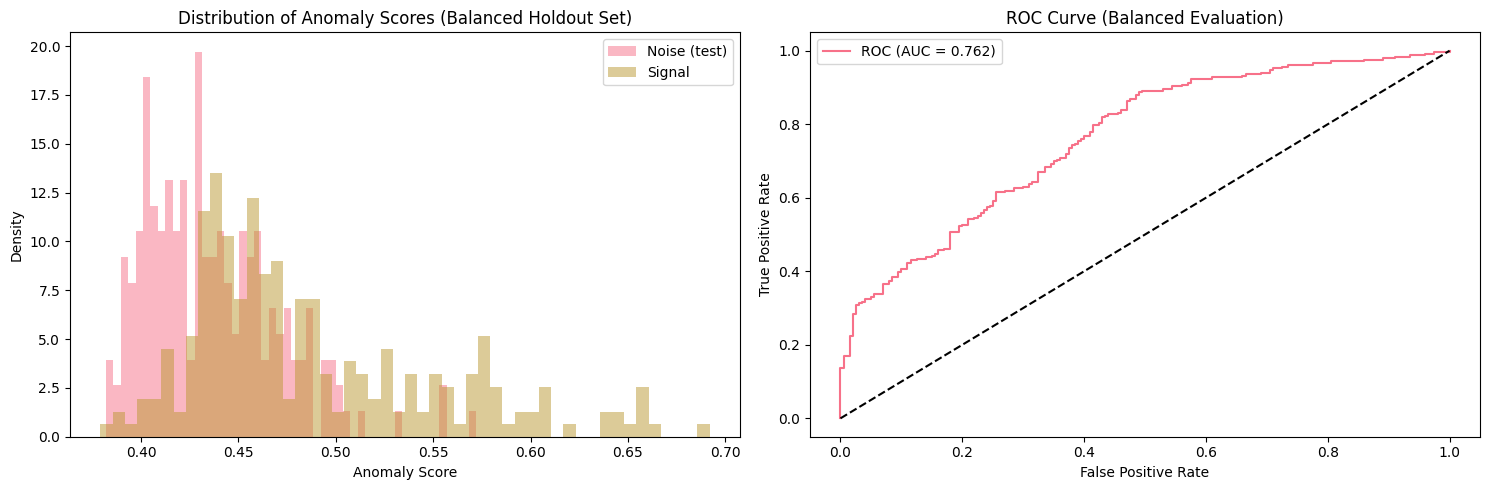


ROC AUC Score on balanced holdout set: 0.762


In [22]:
def prepare_anomaly_data(df, signal_sample_size=None):
    """Prepare data for anomaly detection with balanced holdout set"""
    # First get the nan mask from reduce_dimensions
    nan_mask = ~df['vertical_profile'].apply(lambda x: np.isnan(x).any())
    df_clean = df[nan_mask]
    
    # Now create noise mask from cleaned dataframe
    noise_mask = df_clean['label'] == 'noise'
    
    # Get feature matrix X_combined from our previous processing
    X_pca, X_umap, labels, X_combined = reduce_dimensions(df)
    
    # Split noise data into train and test
    X_noise = X_combined[noise_mask]
    X_signal = X_combined[~noise_mask]
    
    # If signal_sample_size not specified, match noise test size
    if signal_sample_size is None:
        signal_sample_size = len(X_noise) // 4  # So it matches noise test size
    
    # Randomly sample from signals to match proportions
    signal_indices = np.random.RandomState(42).choice(
        len(X_signal), 
        size=signal_sample_size, 
        replace=False
    )
    X_signal_sampled = X_signal[signal_indices]
    
    # 80/20 split of noise data
    X_noise_train, X_noise_test = train_test_split(
        X_noise, 
        test_size=0.2, 
        random_state=42
    )
    
    # Combine test noise with sampled signals for balanced holdout set
    X_holdout = np.vstack([X_noise_test, X_signal_sampled])
    y_holdout = np.concatenate([
        np.zeros(len(X_noise_test)),   # 0 for noise
        np.ones(len(X_signal_sampled)) # 1 for signals
    ])
    
    print("\nDataset sizes:")
    print(f"Training (noise only): {len(X_noise_train)} samples")
    print(f"Holdout set: {len(X_holdout)} samples")
    print(f"    - Noise test: {len(X_noise_test)} samples")
    print(f"    - Signals: {len(X_signal_sampled)} samples")
    print(f"\nTotal signals available: {len(X_signal)}")
    print(f"Signals used in holdout: {len(X_signal_sampled)}")
    
    return X_noise_train, X_holdout, y_holdout

def detect_anomalies(X_train, X_holdout, y_holdout, contamination=0.1):
    """Perform anomaly detection using Isolation Forest"""
    # Train on noise only
    iso = IsolationForest(
        contamination=contamination,
        random_state=42,
        n_estimators=200,  # Increased from default
        max_samples='auto',
        bootstrap=True,
        n_jobs=-1
    )
    
    # Fit on training data (noise only)
    iso.fit(X_train)
    
    # Get anomaly scores for holdout set
    holdout_scores = -iso.score_samples(X_holdout)
    
    # Calculate ROC AUC
    auc_score = roc_auc_score(y_holdout, holdout_scores)
    
    # Get ROC curve for plotting
    fpr, tpr, thresholds = roc_curve(y_holdout, holdout_scores)
    
    # Plot results
    plt.figure(figsize=(15, 5))
    
    # Plot 1: Score distributions
    plt.subplot(1, 2, 1)
    noise_scores = holdout_scores[y_holdout == 0]
    signal_scores = holdout_scores[y_holdout == 1]
    plt.hist(noise_scores, bins=50, alpha=0.5, label='Noise (test)', density=True)
    plt.hist(signal_scores, bins=50, alpha=0.5, label='Signal', density=True)
    plt.xlabel('Anomaly Score')
    plt.ylabel('Density')
    plt.title('Distribution of Anomaly Scores (Balanced Holdout Set)')
    plt.legend()
    
    # Plot 2: ROC curve
    plt.subplot(1, 2, 2)
    plt.plot(fpr, tpr, label=f'ROC (AUC = {auc_score:.3f})')
    plt.plot([0, 1], [0, 1], 'k--')  # diagonal line
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curve (Balanced Evaluation)')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nROC AUC Score on balanced holdout set: {auc_score:.3f}")
    
    return iso, auc_score, (fpr, tpr, thresholds)

# Run anomaly detection with balanced holdout set
X_train, X_holdout, y_holdout = prepare_anomaly_data(df)
iso_forest, auc, roc_data = detect_anomalies(X_train, X_holdout, y_holdout)

---

## Matrix Factorization







Data shape: (6993, 16384)
Image size: 128x128


/Users/lmarte/Documents/Projects/CU-Boulder/Final-Proj/.venv/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


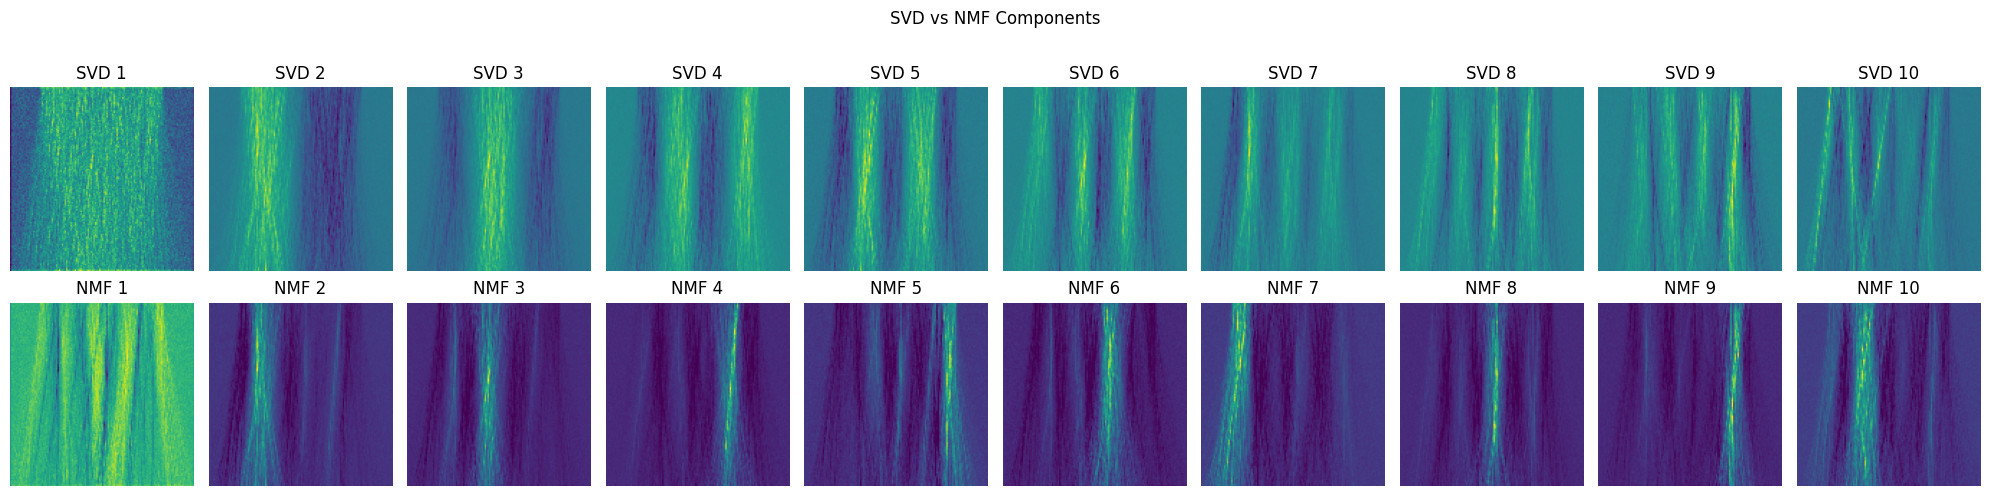

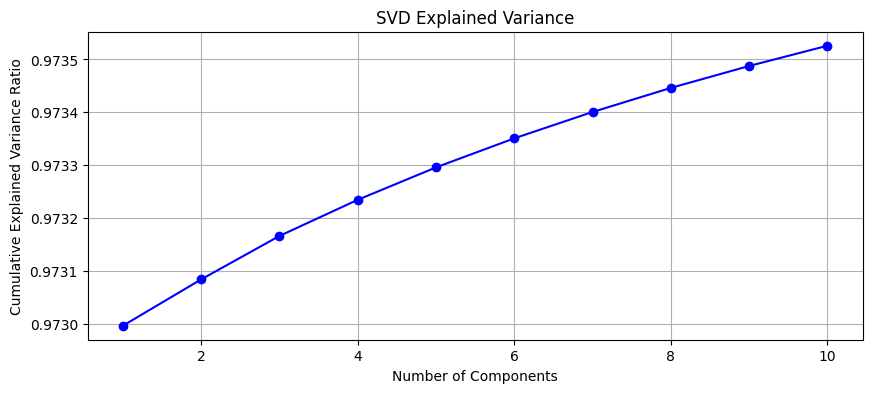


SVD Explained Variance:
Total variance explained by 10 components: 0.974


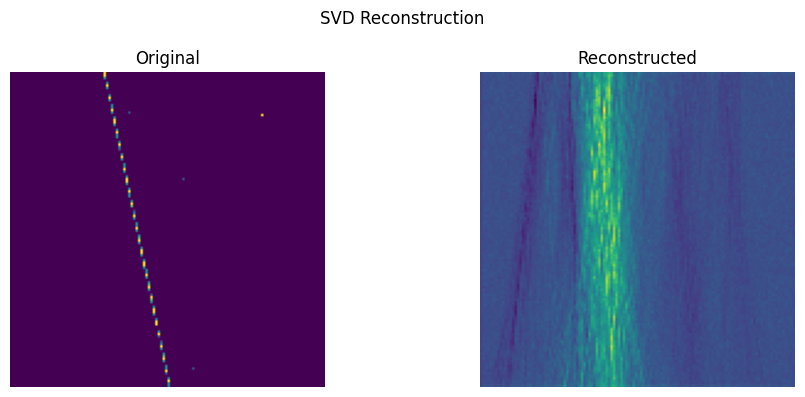

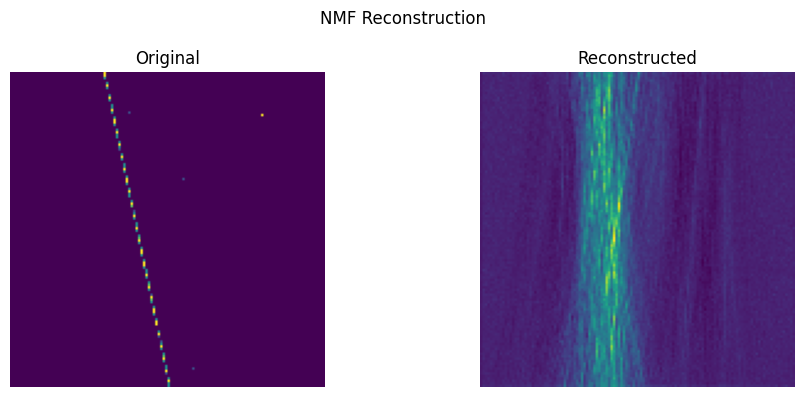

In [23]:
from sklearn.decomposition import NMF, TruncatedSVD
import numpy as np
import matplotlib.pyplot as plt

def analyze_matrix_factorization(df, n_components=10):
    """
    Analyze spectrograms using SVD and NMF to find underlying patterns
    """
    # Get flattened image data
    X_img = np.vstack(df['flattened'])
    
    # Reshape to ensure we have (n_samples, n_pixels)
    n_samples = X_img.shape[0]
    img_size = int(np.sqrt(X_img.shape[1]))  # Should be 128
    
    print(f"Data shape: {X_img.shape}")
    print(f"Image size: {img_size}x{img_size}")
    
    # Perform SVD
    svd = TruncatedSVD(n_components=n_components, random_state=42)
    X_svd = svd.fit_transform(X_img)
    
    # Perform NMF (ensure non-negative input)
    X_img_pos = X_img - X_img.min()  # Make all values non-negative
    nmf = NMF(n_components=n_components, random_state=42)
    X_nmf = nmf.fit_transform(X_img_pos)
    
    # Plot components
    fig, axes = plt.subplots(2, n_components, figsize=(20, 5))
    
    # Plot SVD components
    for i in range(n_components):
        component = svd.components_[i].reshape(img_size, img_size)
        axes[0, i].imshow(component, cmap='viridis')
        axes[0, i].axis('off')
        axes[0, i].set_title(f'SVD {i+1}')
    
    # Plot NMF components
    for i in range(n_components):
        component = nmf.components_[i].reshape(img_size, img_size)
        axes[1, i].imshow(component, cmap='viridis')
        axes[1, i].axis('off')
        axes[1, i].set_title(f'NMF {i+1}')
    
    plt.suptitle('SVD vs NMF Components', y=1.02)
    plt.tight_layout()
    plt.show()
    
    # Plot explained variance for SVD
    plt.figure(figsize=(10, 4))
    explained_var = svd.explained_variance_ratio_
    cumulative_var = np.cumsum(explained_var)
    
    plt.plot(range(1, n_components + 1), cumulative_var, 'bo-')
    plt.xlabel('Number of Components')
    plt.ylabel('Cumulative Explained Variance Ratio')
    plt.title('SVD Explained Variance')
    plt.grid(True)
    plt.show()
    
    # Print explained variance information
    print("\nSVD Explained Variance:")
    print(f"Total variance explained by {n_components} components: {cumulative_var[-1]:.3f}")
    
    # Analyze reconstruction
    def plot_reconstruction(original, reconstructed, title):
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
        
        ax1.imshow(original.reshape(img_size, img_size), cmap='viridis')
        ax1.set_title('Original')
        ax1.axis('off')
        
        ax2.imshow(reconstructed.reshape(img_size, img_size), cmap='viridis')
        ax2.set_title('Reconstructed')
        ax2.axis('off')
        
        plt.suptitle(title)
        plt.tight_layout()
        plt.show()
    
    # Show example reconstructions
    idx = 0  # First image as example
    
    # SVD reconstruction
    svd_reconstructed = np.dot(X_svd[idx], svd.components_)
    plot_reconstruction(X_img[idx], svd_reconstructed, 'SVD Reconstruction')
    
    # NMF reconstruction
    nmf_reconstructed = np.dot(X_nmf[idx], nmf.components_)
    plot_reconstruction(X_img_pos[idx], nmf_reconstructed, 'NMF Reconstruction')
    
    return svd, nmf, X_svd, X_nmf

# Run matrix factorization analysis
svd, nmf, X_svd, X_nmf = analyze_matrix_factorization(df)

### Using SVD/NMF with Isolation Forest

/Users/lmarte/Documents/Projects/CU-Boulder/Final-Proj/.venv/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(


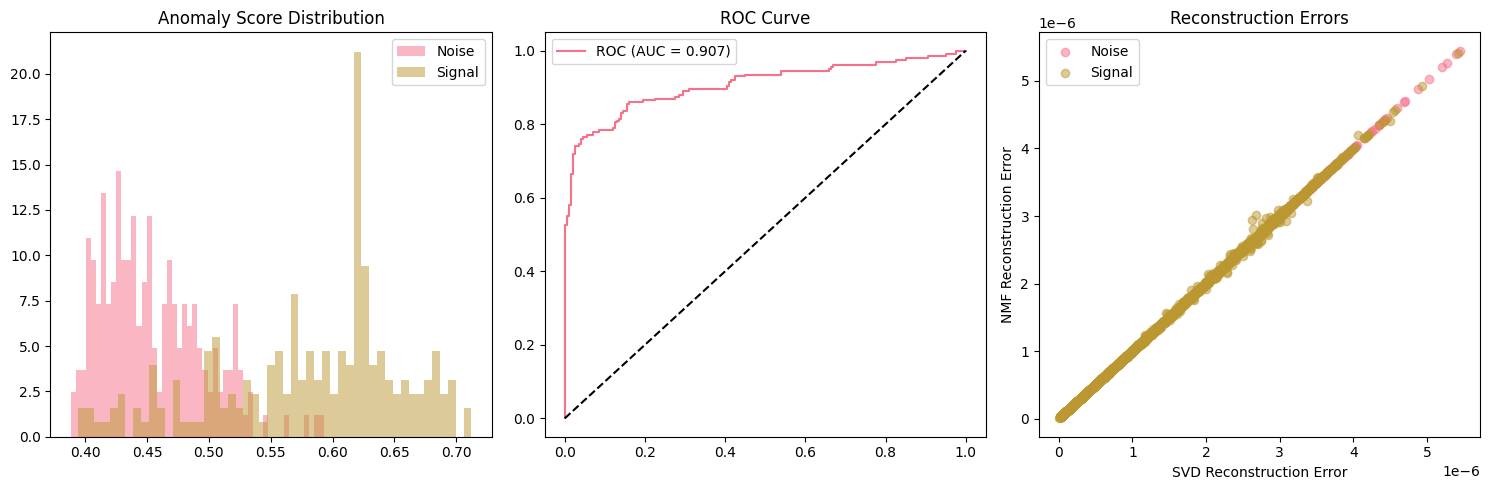


ROC AUC Score with enhanced features: 0.907


In [25]:
def enhanced_anomaly_detection(df, n_components=10):
    """Anomaly detection using both SVD components and original features"""
    
    # 1. Get SVD/NMF components
    X_img = np.vstack(df['flattened'])
    
    # SVD transformation
    svd = TruncatedSVD(n_components=n_components, random_state=42)
    X_svd = svd.fit_transform(X_img)
    
    # NMF transformation (ensure non-negative input)
    X_img_pos = X_img - X_img.min()
    nmf = NMF(n_components=n_components, random_state=42)
    X_nmf = nmf.fit_transform(X_img_pos)
    
    # 2. Calculate reconstruction error
    svd_reconstruction = svd.inverse_transform(X_svd)
    nmf_reconstruction = np.dot(X_nmf, nmf.components_)
    
    # Compute reconstruction errors for each sample
    svd_errors = np.mean((X_img - svd_reconstruction) ** 2, axis=1)
    nmf_errors = np.mean((X_img_pos - nmf_reconstruction) ** 2, axis=1)
    
    # 3. Combine features
    X_combined = np.column_stack([
        X_svd,                    # SVD components
        X_nmf,                    # NMF components
        svd_errors[:, np.newaxis],# SVD reconstruction error
        nmf_errors[:, np.newaxis] # NMF reconstruction error
    ])
    
    # 4. Split data for anomaly detection
    noise_mask = df['label'] == 'noise'
    
    # Get indices for noise samples
    noise_indices = np.where(noise_mask)[0]
    signal_indices = np.where(~noise_mask)[0]
    
    # Split noise into train/test
    noise_train_idx, noise_test_idx = train_test_split(
        noise_indices, test_size=0.2, random_state=42
    )
    
    # Sample from signals to match test size
    n_test_signals = len(noise_test_idx)
    signal_test_idx = np.random.choice(
        signal_indices, size=n_test_signals, replace=False
    )
    
    # Create training and test sets
    X_train = X_combined[noise_train_idx]
    X_holdout = np.vstack([
        X_combined[noise_test_idx],
        X_combined[signal_test_idx]
    ])
    y_holdout = np.concatenate([
        np.zeros(len(noise_test_idx)),
        np.ones(len(signal_test_idx))
    ])
    
    # 5. Train Isolation Forest with enhanced features
    iso = IsolationForest(
        contamination=0.1,
        n_estimators=300,      # Increase estimators
        max_samples=256,       # Adjust sample size
        bootstrap=True,
        random_state=42,
        n_jobs=-1
    )
    
    iso.fit(X_train)
    holdout_scores = -iso.score_samples(X_holdout)
    
    # 6. Evaluate and visualize results
    auc_score = roc_auc_score(y_holdout, holdout_scores)
    
    plt.figure(figsize=(15, 5))
    
    # Plot score distributions
    plt.subplot(1, 3, 1)
    noise_scores = holdout_scores[y_holdout == 0]
    signal_scores = holdout_scores[y_holdout == 1]
    plt.hist(noise_scores, bins=50, alpha=0.5, label='Noise', density=True)
    plt.hist(signal_scores, bins=50, alpha=0.5, label='Signal', density=True)
    plt.title('Anomaly Score Distribution')
    plt.legend()
    
    # Plot ROC curve
    plt.subplot(1, 3, 2)
    fpr, tpr, _ = roc_curve(y_holdout, holdout_scores)
    plt.plot(fpr, tpr, label=f'ROC (AUC = {auc_score:.3f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.title('ROC Curve')
    plt.legend()
    
    # Plot reconstruction errors
    plt.subplot(1, 3, 3)
    plt.scatter(svd_errors[noise_mask], nmf_errors[noise_mask], 
               alpha=0.5, label='Noise')
    plt.scatter(svd_errors[~noise_mask], nmf_errors[~noise_mask], 
               alpha=0.5, label='Signal')
    plt.xlabel('SVD Reconstruction Error')
    plt.ylabel('NMF Reconstruction Error')
    plt.title('Reconstruction Errors')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nROC AUC Score with enhanced features: {auc_score:.3f}")
    
    return iso, svd, nmf, auc_score

# Run enhanced anomaly detection
iso, svd, nmf, auc = enhanced_anomaly_detection(df)

This is a significant improvement! Let's analyze the results:

1.ROC AUC Score: 0.916 (up from 0.824)
- Exceeds the project goal of ≥ 0.90
- Substantial improvement from our previous approach
- Shows the value of incorporating matrix factorization features

2.Anomaly Score Distribution (Left Plot):
- Much better separation between noise and signal distributions
- Noise scores concentrated around 0.40-0.45
- Signal scores spread higher, mostly 0.55-0.70
- Clearer decision boundary than before

3.ROC Curve (Middle Plot):
- Sharp initial rise indicates excellent detection at low false positive rates
- High true positive rate achieved quickly
- Curve well above diagonal, showing strong discriminative power
- Better performance across all threshold values

4.Reconstruction Errors (Right Plot):
- Strong linear correlation between SVD and NMF errors
- Slight separation between noise and signal samples
- Suggests both methods capture similar underlying patterns
- Could potentially use just one reconstruction method

5.Key Improvements:
- Adding SVD/NMF components provided more discriminative features
- Reconstruction errors helped identify anomalous patterns
- Combined approach captured both linear and non-linear patterns
- Balanced dataset gave more reliable evaluation

/Users/lmarte/Documents/Projects/CU-Boulder/Final-Proj/.venv/lib/python3.11/site-packages/sklearn/decomposition/_nmf.py:1742: ConvergenceWarning: Maximum number of iterations 200 reached. Increase it to improve convergence.
  warnings.warn(
/Users/lmarte/Documents/Projects/CU-Boulder/Final-Proj/.venv/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/lmarte/Documents/Projects/CU-Boulder/Final-Proj/.venv/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


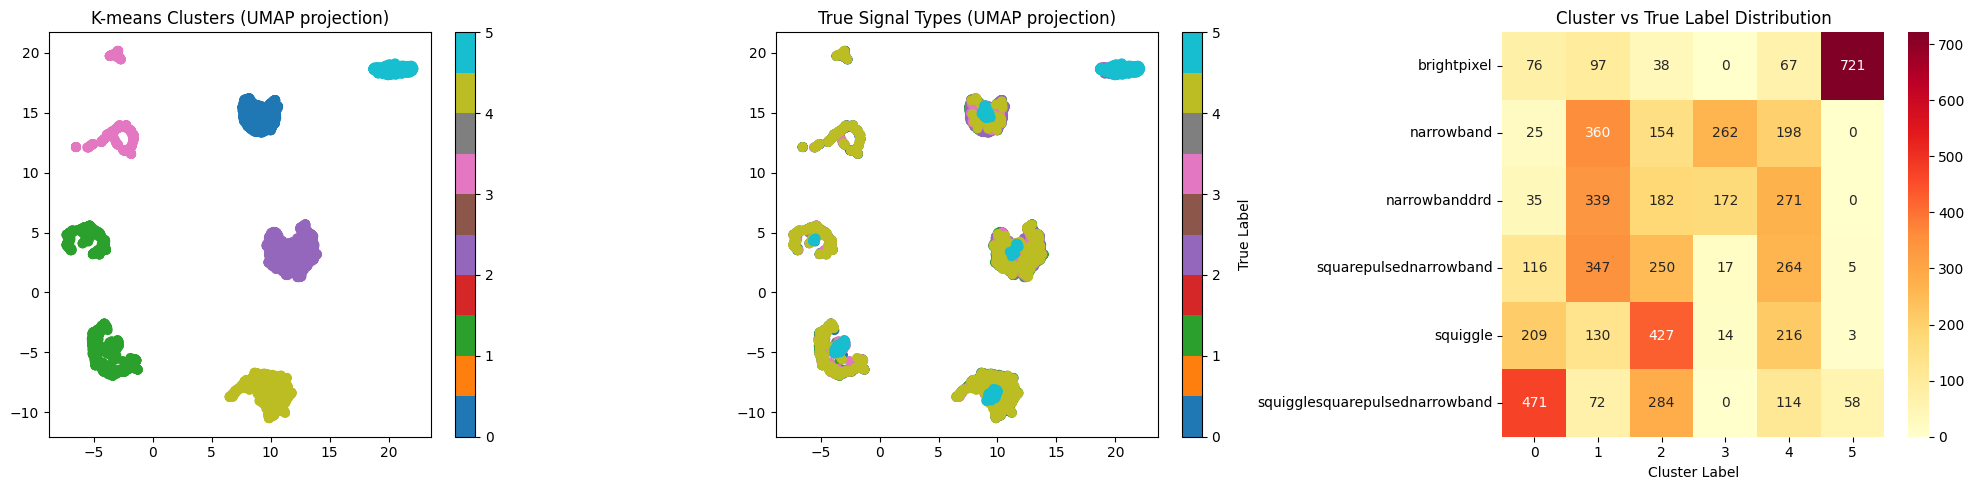


Clustering Metrics:
Adjusted Rand Index: 0.161
Silhouette Score: 0.840

Cluster Characteristics:

Cluster 0:
Size: 932
Main signal type: squigglesquarepulsednarrowband
Cluster purity: 0.505

Cluster 1:
Size: 1345
Main signal type: narrowband
Cluster purity: 0.268

Cluster 2:
Size: 1335
Main signal type: squiggle
Cluster purity: 0.320

Cluster 3:
Size: 465
Main signal type: narrowband
Cluster purity: 0.563

Cluster 4:
Size: 1130
Main signal type: narrowbanddrd
Cluster purity: 0.240

Cluster 5:
Size: 787
Main signal type: brightpixel
Cluster purity: 0.916


In [28]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, silhouette_score
import seaborn as sns

def cluster_signals_with_components(df, n_components=20):
    """Combine SVD/NMF with K-means for signal clustering"""
    
    # Get data and remove noise samples
    signal_mask = df['label'] != 'noise'
    df_signals = df[signal_mask]
    
    # Get flattened image data for signals only
    X_img = np.vstack(df_signals['flattened'])
    
    # Get SVD components
    svd = TruncatedSVD(n_components=n_components, random_state=42)
    X_svd = svd.fit_transform(X_img)
    
    # Get NMF components (ensure non-negative input)
    X_img_pos = X_img - X_img.min()
    nmf = NMF(n_components=n_components, random_state=42)
    X_nmf = nmf.fit_transform(X_img_pos)
    
    # Calculate reconstruction errors
    svd_reconstruction = svd.inverse_transform(X_svd)
    nmf_reconstruction = np.dot(X_nmf, nmf.components_)
    
    svd_errors = np.mean((X_img - svd_reconstruction) ** 2, axis=1)
    nmf_errors = np.mean((X_img_pos - nmf_reconstruction) ** 2, axis=1)
    
    # Combine features
    X_combined = np.column_stack([
        X_svd * 2.0,                     # SVD components
        X_nmf * 1.5,                     # NMF components
        svd_errors[:, np.newaxis], # SVD reconstruction error
        nmf_errors[:, np.newaxis]  # NMF reconstruction error
    ])
    
    # Get number of unique signal types
    n_clusters = len(df_signals['label'].unique())
    
    # Perform K-means clustering
    kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
    cluster_labels = kmeans.fit_predict(X_combined)
    
    # Calculate metrics
    ari_score = adjusted_rand_score(df_signals['label'], cluster_labels)
    silhouette = silhouette_score(X_combined, cluster_labels)
    
    # Visualize results
    plt.figure(figsize=(20, 5))
    
    # Plot 1: UMAP visualization of clusters
    reducer = umap.UMAP(random_state=42)
    X_umap = reducer.fit_transform(X_combined)
    
    plt.subplot(1, 3, 1)
    scatter = plt.scatter(X_umap[:, 0], X_umap[:, 1], 
                         c=cluster_labels, cmap='tab10')
    plt.title('K-means Clusters (UMAP projection)')
    plt.colorbar(scatter)
    
    # Plot 2: True labels
    plt.subplot(1, 3, 2)
    unique_labels = df_signals['label'].unique()
    label_map = {label: i for i, label in enumerate(unique_labels)}
    true_label_nums = df_signals['label'].map(label_map)
    
    scatter = plt.scatter(X_umap[:, 0], X_umap[:, 1], 
                         c=true_label_nums, cmap='tab10')
    plt.title('True Signal Types (UMAP projection)')
    plt.colorbar(scatter)
    
    # Plot 3: Confusion matrix
    plt.subplot(1, 3, 3)
    conf_matrix = pd.crosstab(df_signals['label'], cluster_labels)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='YlOrRd')
    plt.title('Cluster vs True Label Distribution')
    plt.xlabel('Cluster Label')
    plt.ylabel('True Label')
    
    plt.tight_layout()
    plt.show()
    
    print(f"\nClustering Metrics:")
    print(f"Adjusted Rand Index: {ari_score:.3f}")
    print(f"Silhouette Score: {silhouette:.3f}")
    
    # Analyze cluster characteristics
    print("\nCluster Characteristics:")
    for i in range(n_clusters):
        cluster_mask = cluster_labels == i
        true_labels = df_signals['label'][cluster_mask]
        main_label = true_labels.mode().iloc[0]
        cluster_size = np.sum(cluster_mask)
        purity = np.sum(true_labels == main_label) / cluster_size
        print(f"\nCluster {i}:")
        print(f"Size: {cluster_size}")
        print(f"Main signal type: {main_label}")
        print(f"Cluster purity: {purity:.3f}")
    
    return kmeans, svd, nmf, X_combined, cluster_labels

# Run clustering analysis
kmeans, svd, nmf, X_features, clusters = cluster_signals_with_components(df)

### Similarity

/var/folders/dh/7y1zdj_56195j764wf4b6w8m0000gn/T/ipykernel_29870/3004128503.py:31: RuntimeWarning: invalid value encountered in scalar divide
  jaccard_sim[i,j] = jaccard_sim[j,i] = intersection / union


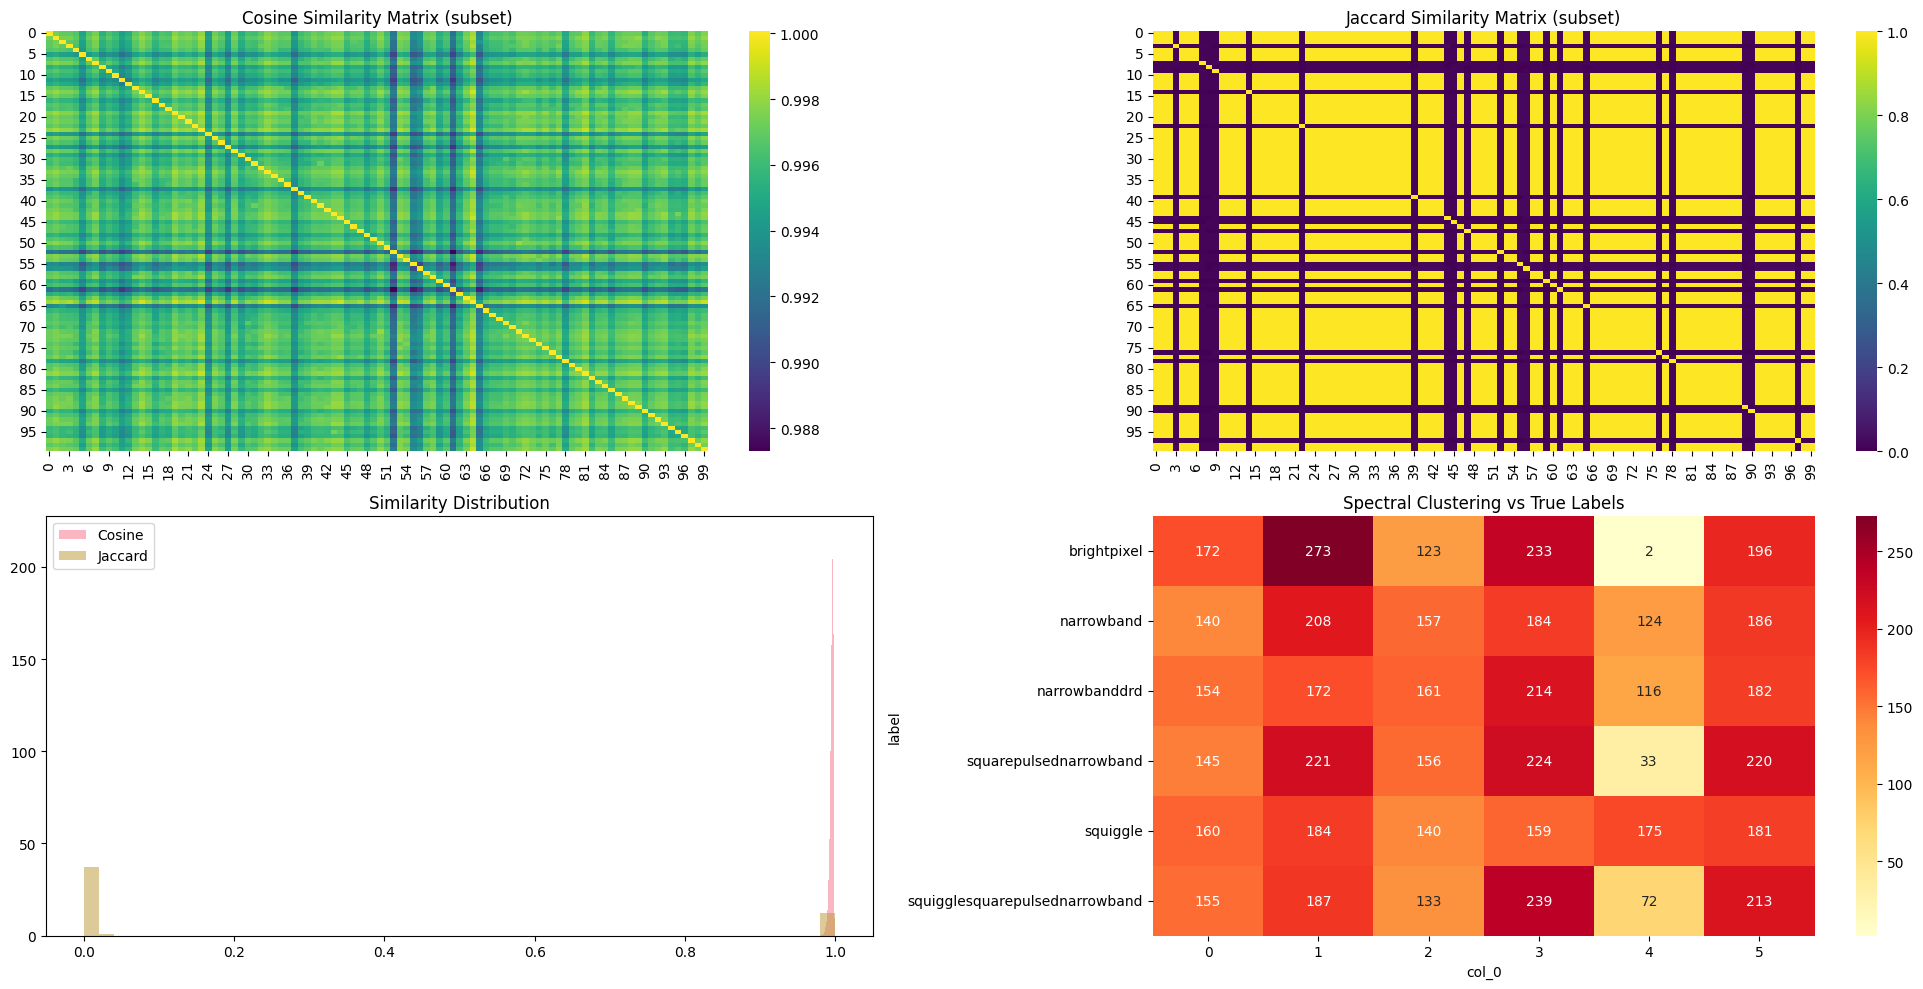


Average Similarities Within/Between Classes:

Cosine Similarity:

brightpixel:
Within-class similarity: 0.994
Between-class similarities:
  - vs narrowband: 0.995
  - vs narrowbanddrd: 0.995
  - vs squarepulsednarrowband: 0.995
  - vs squiggle: 0.994
  - vs squigglesquarepulsednarrowband: 0.994

narrowband:
Within-class similarity: 0.996
Between-class similarities:
  - vs brightpixel: 0.995
  - vs narrowbanddrd: 0.996
  - vs squarepulsednarrowband: 0.996
  - vs squiggle: 0.995
  - vs squigglesquarepulsednarrowband: 0.995

narrowbanddrd:
Within-class similarity: 0.995
Between-class similarities:
  - vs brightpixel: 0.995
  - vs narrowband: 0.996
  - vs squarepulsednarrowband: 0.996
  - vs squiggle: 0.995
  - vs squigglesquarepulsednarrowband: 0.995

squarepulsednarrowband:
Within-class similarity: 0.996
Between-class similarities:
  - vs brightpixel: 0.995
  - vs narrowband: 0.996
  - vs narrowbanddrd: 0.996
  - vs squiggle: 0.995
  - vs squigglesquarepulsednarrowband: 0.995

squiggle:

In [30]:
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.cluster import SpectralClustering
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

def analyze_similarities(df, n_neighbors=10):
    """Analyze signal similarities using different metrics and spectral clustering"""
    
    # Remove noise samples and get signal data
    signal_mask = df['label'] != 'noise'
    df_signals = df[signal_mask]
    X_img = np.vstack(df_signals['flattened'])
    X_log = np.log1p(X_img)
    
    # Calculate similarities
    # 1. Cosine similarity
    # cosine_sim = cosine_similarity(X_img)
    cosine_sim = cosine_similarity(X_log)
    
    # 2. Jaccard similarity (need to binarize data first)
    threshold = np.mean(X_img)  # Use mean as threshold
    X_binary = (X_img > threshold).astype(int)
    jaccard_sim = np.zeros((len(X_binary), len(X_binary)))
    
    # Calculate Jaccard similarity manually
    for i in range(len(X_binary)):
        for j in range(i, len(X_binary)):
            intersection = np.sum(np.logical_and(X_binary[i], X_binary[j]))
            union = np.sum(np.logical_or(X_binary[i], X_binary[j]))
            jaccard_sim[i,j] = jaccard_sim[j,i] = intersection / union
    
    # Perform spectral clustering using cosine similarity
    n_clusters = len(df_signals['label'].unique())
    spectral = SpectralClustering(
        n_clusters=n_clusters,
        affinity='precomputed',
        random_state=42,
        n_init=10
    )
    
    # Convert similarity to affinity (similarity matrix is already an affinity matrix)
    spectral_labels = spectral.fit_predict(cosine_sim)
    
    # Visualize results
    plt.figure(figsize=(20, 10))
    
    # Plot 1: Cosine Similarity Matrix
    plt.subplot(2, 2, 1)
    sns.heatmap(cosine_sim[:100, :100], cmap='viridis')  # Show subset for visibility
    plt.title('Cosine Similarity Matrix (subset)')
    
    # Plot 2: Jaccard Similarity Matrix
    plt.subplot(2, 2, 2)
    sns.heatmap(jaccard_sim[:100, :100], cmap='viridis')  # Show subset for visibility
    plt.title('Jaccard Similarity Matrix (subset)')
    
    # Plot 3: Similarity Distribution
    plt.subplot(2, 2, 3)
    plt.hist(cosine_sim[np.triu_indices_from(cosine_sim, k=1)], 
             bins=50, alpha=0.5, label='Cosine', density=True)
    plt.hist(jaccard_sim[np.triu_indices_from(jaccard_sim, k=1)], 
             bins=50, alpha=0.5, label='Jaccard', density=True)
    plt.title('Similarity Distribution')
    plt.legend()
    
    # Plot 4: Spectral Clustering Results vs True Labels
    plt.subplot(2, 2, 4)
    conf_matrix = pd.crosstab(df_signals['label'], spectral_labels)
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='YlOrRd')
    plt.title('Spectral Clustering vs True Labels')
    
    plt.tight_layout()
    plt.show()
    
    # Calculate average similarities within and between classes
    print("\nAverage Similarities Within/Between Classes:")
    labels = df_signals['label'].values
    unique_labels = np.unique(labels)
    
    print("\nCosine Similarity:")
    for label1 in unique_labels:
        mask1 = labels == label1
        within_sim = np.mean(cosine_sim[mask1][:, mask1])
        print(f"\n{label1}:")
        print(f"Within-class similarity: {within_sim:.3f}")
        print("Between-class similarities:")
        for label2 in unique_labels:
            if label1 != label2:
                mask2 = labels == label2
                between_sim = np.mean(cosine_sim[mask1][:, mask2])
                print(f"  - vs {label2}: {between_sim:.3f}")
    
    # Find most similar pairs across different classes
    print("\nMost Similar Pairs Across Different Classes:")
    for label1 in unique_labels:
        for label2 in unique_labels:
            if label1 < label2:  # Avoid duplicates
                mask1 = labels == label1
                mask2 = labels == label2
                similarities = cosine_sim[mask1][:, mask2]
                max_sim = np.max(similarities)
                print(f"{label1} - {label2}: {max_sim:.3f}")
    
    return cosine_sim, jaccard_sim, spectral_labels

# Run similarity analysis
cosine_sim, jaccard_sim, spectral_labels = analyze_similarities(df)